# KKBox's Churn Prediction Challenge

This is a case study on KKBox’s Churn Prediction Challenge dataset
from Kaggle.

_KKBox is Asia’s top music streaming service with over 10 million users, featuring
over 10 million music tracks. KKBOX offers unlimited and on-demand music with
a single monthly subscription fee for users to stream online or download from
their smartphones, tablets and PCs._

In this case study, I build an algorithm that predicts whether a user will churn after their subscription expires.

_Churn means a customer/user does not re-subscribe within 30 days after
expiration of their subscription._

Knowing that a user will probably churn and the reasons behind it, will
help a company to improve their services and retain their customers
as well.

KKBox has provided the train and test datasets for this task. 
Below are the details of the data provided by the KKBox for this case
study.

1. Train Class Labels data (trainv2.csv file) – It contains the churn data
for March and has two columns
· msno – user id
· is_churn – 1 (churn) ; 0 (re-subscribed)

2. Test Class Label data (sample_submission_v2.csv file) – It contains the churn data for
March and has two columns
· msno – user id
· is_churn – 1 (churn) ; 0 (re-subscribed)

3. Members (members_v3.csv file) – It contains data about the users, but not
for every user and has following columns:
· msno
· city
· bd – age
· gender
· registered_via: registration method
· registration_init_time: format %Y%m%d
· expiration_date: format %Y%m%d, taken as a snapshot at which
the member.csv is extracted. Not representing the actual churn
behavior.

4. Transactions of users (transactions_v2.csv file) – It contains transactions
data of users 
· msno: user id
· payment_method_id: payment method
· payment_plan_days: length of membership plan in days
· plan_list_price: in New Taiwan Dollar (NTD)
· actual_amount_paid: in New Taiwan Dollar (NTD)
· is_auto_renew
· transaction_date: format %Y%m%d
· membership_expire_date: format %Y%m%d
· is_cancel: whether or not the user canceled the membership in
this transaction.

5. User logs (user_logs_v2.csv file): It contains daily user logs
describing listening behaviours of a user.
· msno: user id
· date: format %Y%m%d
· num_25: # of songs played less than 25% of the song length
· num_50: # of songs played between 25% to 50% of the song
length
· num_75: # of songs played between 50% to 75% of of the song
length
· num_985: # of songs played between 75% to 98.5% of the song
length
· num_100: # of songs played over 98.5% of the song length
· num_unq: # of unique songs played
· total_secs: total seconds played


### EDA (Exploratory Data Analysis)

In [1]:
# import libraries
import warnings 
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline

import pandas as pd
import dask.dataframe as dd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sn
import os
import py7zr
from zipfile import ZipFile
from datetime import datetime

import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [4]:
file_name = "kkbox-churn-prediction-challenge.zip"

In [5]:
with ZipFile(file_name,'r') as zipfile:
    zipfile.printdir()  # printing all the contents of zipfile
    
    # extracting all the files
    print("Extracting all the zipfiles now")
    zipfile.extractall("input")  #extracting files in a folder "input" 

File Name                                             Modified             Size
WSDMChurnLabeller.scala                        2019-12-12 00:08:24         7050
members_v3.csv.7z                              2019-12-12 00:08:32    242308558
sample_submission_v2.csv.7z                    2019-12-12 00:09:24     30666957
sample_submission_zero.csv.7z                  2019-12-12 00:09:28     32828332
train.csv.7z                                   2019-12-12 00:09:36     33563098
train_v2.csv.7z                                2019-12-12 00:09:42     32818991
transactions.csv.7z                            2019-12-12 00:09:46    707508779
transactions_v2.csv.7z                         2019-12-12 00:11:40     48850410
user_logs.csv.7z                               2019-12-12 00:11:46   7136060375
user_logs_v2.csv.7z                            2019-12-12 00:33:28    685951221
Extracting all the zipfiles now


In [50]:
for file in os.listdir("input"):
    if (file != "WSDMChurnLabeller.scala") and (file!=".ipynb_checkpoints"):
        print(f"Unzipping - {file}")
        archive = py7zr.SevenZipFile(f"input/{file}", mode='r')
        archive.extractall(path="input_files")
        print(f"Unzipped  {file}")
        print("="*30)
        archive.close()

Unzipping - user_logs_v2.csv.7z
Unzipped  user_logs_v2.csv.7z
Unzipping - train.csv.7z
Unzipped  train.csv.7z
Unzipping - sample_submission_zero.csv.7z
Unzipped  sample_submission_zero.csv.7z
Unzipping - transactions.csv.7z
Unzipped  transactions.csv.7z
Unzipping - transactions_v2.csv.7z
Unzipped  transactions_v2.csv.7z
Unzipping - train_v2.csv.7z
Unzipped  train_v2.csv.7z
Unzipping - members_v3.csv.7z
Unzipped  members_v3.csv.7z
Unzipping - sample_submission_v2.csv.7z
Unzipped  sample_submission_v2.csv.7z
Unzipping - user_logs.csv.7z
Unzipped  user_logs.csv.7z


### Reading Input Data

In [43]:
trainv2 = pd.read_csv("input_files/train_v2.csv",dtype={'is_churn':np.int8})
print(trainv2.shape)
trainv2.head()

(970960, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [44]:

sample_submission_v2 = pd.read_csv("input_files/sample_submission_v2.csv",dtype={'is_churn':np.int8})
print(len(sample_submission_v2))
sample_submission_v2.head()


907471


,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [45]:
transactions_v2 = pd.read_csv("input_files/transactions_v2.csv",
                              dtype={'payment_method_id':np.int8,'payment_plan_days':np.int16,'plan_list_price':np.int16,
                                    'actual_amount_paid':np.int16,'is_auto_renew':np.int8,'is_cancel':np.int8})
print(len(transactions_v2))
transactions_v2.head()


1431009


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [46]:
members = pd.read_csv("input_files/members_v3.csv",
                     dtype={'city':np.int8,'bd':np.int16,'registered_via':np.int8})
print((members.shape))
members.head()

(6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [47]:

user_logs_v2 = pd.read_csv("input_files/user_logs_v2.csv",
                     dtype={'num_25': np.int16,'num_50': np.int16,'num_75': np.int16,'num_985': np.int16,'num_100': np.int16})
print(user_logs_v2.shape)
user_logs_v2.head()


(18396362, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


### EDA, Data Cleaning and Preprocessing

In [48]:
# sorting all rows by 'transaction_date' in descending order
transactions_v2 = transactions_v2.sort_values(by='transaction_date',ascending=False)
transactions_v2.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
1199340,aKP16t82xpiU6donvP21pmmozVn6YzCGHYR2UB79/gI=,34,30,149,149,1,20170331,20170430,0
1249243,a1Cc2QvP3E0NJOAmfHoHok+/Vmd7yy1uq6XYpsaQiP0=,41,30,100,100,1,20170331,20170430,0
234686,uCrRmrr1xrz5YF9Vt+TM2Hgc3nvW/Vw7gac+6L6c6NI=,41,30,99,99,1,20170331,20170430,0
498998,luNHumFuvN52PF4wunvCPB2SSEqZPulWhqJ03bwvYyg=,39,30,149,149,1,20170331,20170506,0
234688,uE5BJaui8jWgqNh6qqX5GC6mO35sQ5YgLExtV6Jyu5E=,39,30,149,149,1,20170331,20170514,0


In [49]:
# dropping duplicates if there are any
transactions_v2.drop_duplicates(inplace=True)
print("Shape of transactions dataframe after dropping duplicates = ",transactions_v2.shape)

Shape of transactions dataframe after dropping duplicates =  (1431009, 9)


In [50]:
# checking if there are any NaN values
transactions_v2.isna().sum()

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

There are no NaN or Null in transactions dataset

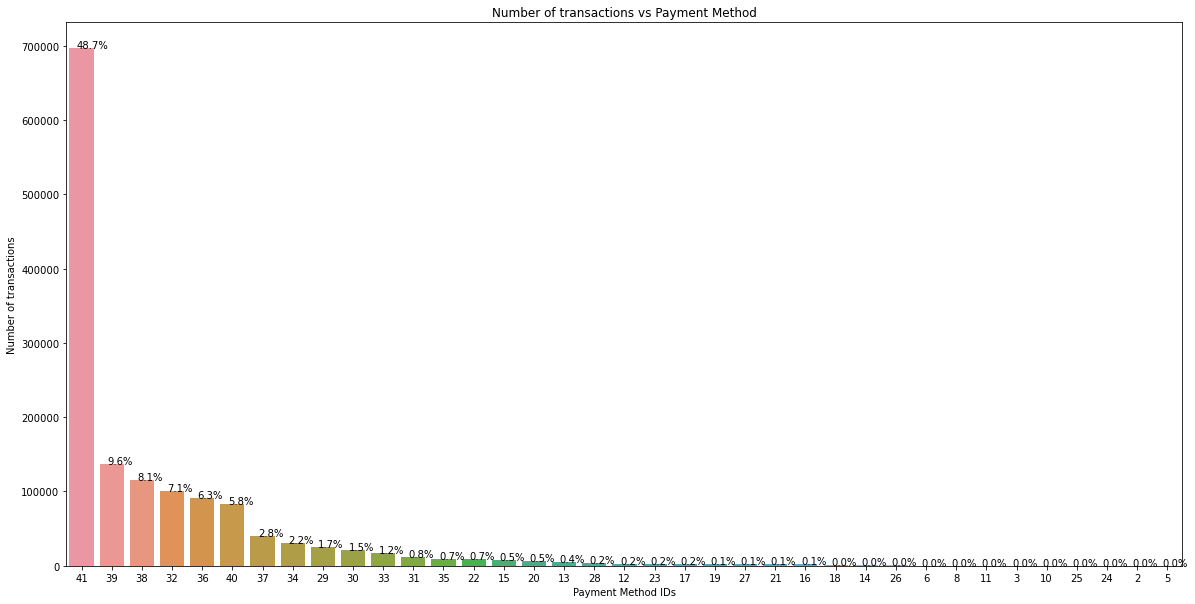

In [10]:
#plot of payment method id vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(transactions_v2.payment_method_id, order=transactions_v2.payment_method_id.value_counts().index)
plt.xlabel("Payment Method IDs")
plt.ylabel("Number of transactions")
plt.title("Number of transactions vs Payment Method")

total = transactions_v2.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### The most used `payment_method_id` is `41`. It counts somewhere around 69000 which is almost 48.7% of the total number of transactions.
##### Other `payment_method_id` having significant count are `39, 38, 32, 36, 40`

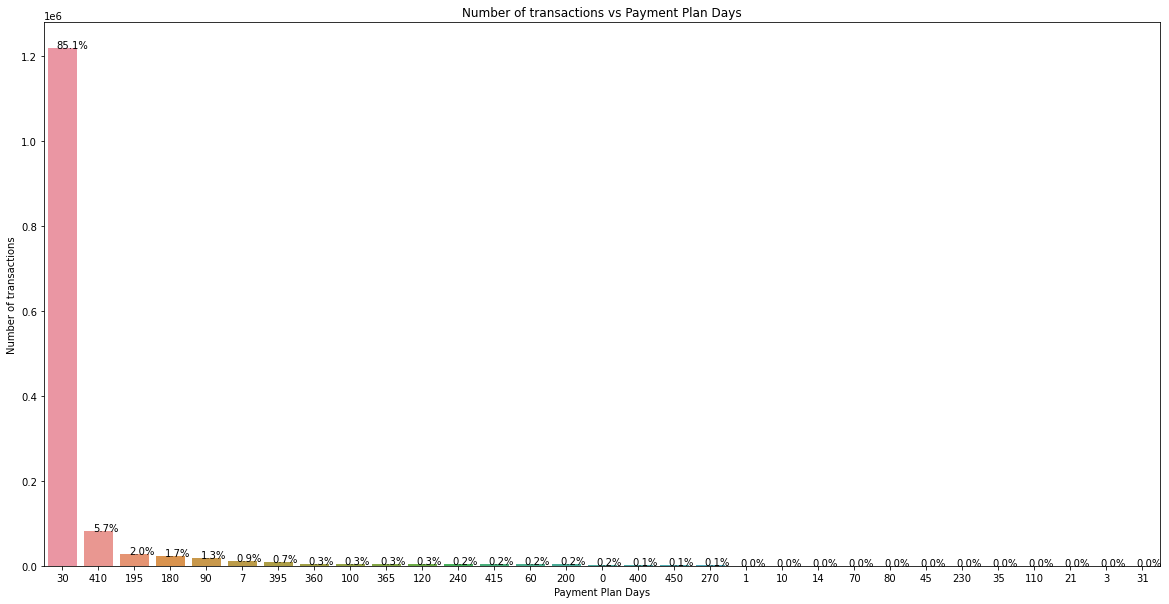

In [11]:
#plot of payment method id vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(transactions_v2.payment_plan_days, order=transactions_v2.payment_plan_days.value_counts().index)
plt.xlabel("Payment Plan Days")
plt.ylabel("Number of transactions")
plt.title("Number of transactions vs Payment Plan Days")

total = transactions_v2.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### 85.1% of the users have a plan of 30 days, there are few users who have a plan of 410, 195,180 and 90 days. 
##### Other plans have very few users compared to 30 days plan

Text(0.5, 1.0, 'Number of transactions vs Plan list price')

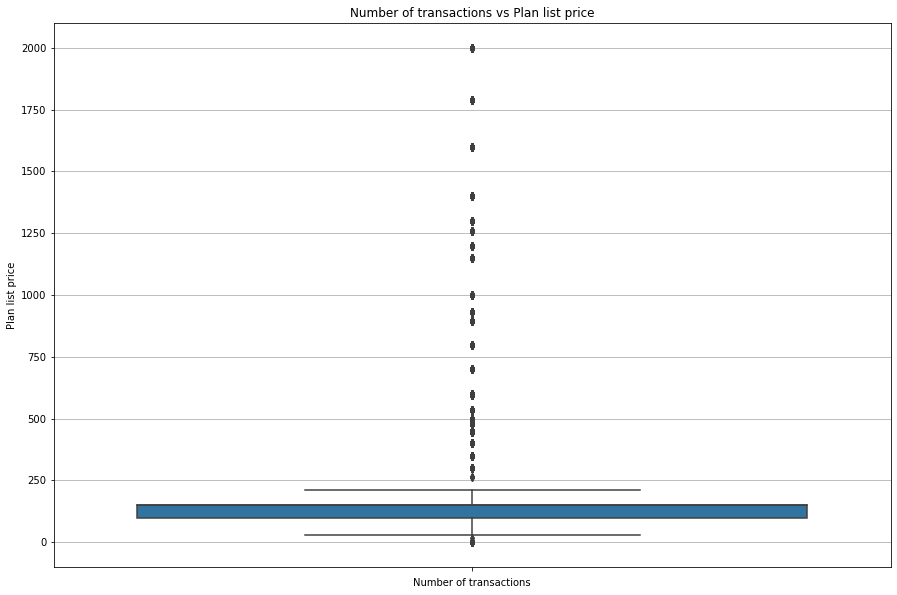

In [12]:
# BoxPlot of Plan list price for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=transactions_v2.plan_list_price, orient='v')
plt.xlabel("Number of transactions")
plt.ylabel("Plan list price")
plt.title("Number of transactions vs Plan list price")

##### Plot shows that more than 75% of transactions have price below 250.

In [13]:
# function to get the percentile values by passing dataframe and column
def percentile(data,column,min_lim=1,max_lim=101,diff=3):
    for i in np.arange(min_lim,max_lim,diff):
        print(f"{i} percentile = ",np.percentile(data[column], i))

In [14]:
#printing percentile of 'plan_list_price' 
percentile(transactions_v2,'plan_list_price',1,101,3) 

1 percentile =  0.0
4 percentile =  99.0
7 percentile =  99.0
10 percentile =  99.0
13 percentile =  99.0
16 percentile =  99.0
19 percentile =  99.0
22 percentile =  99.0
25 percentile =  99.0
28 percentile =  99.0
31 percentile =  100.0
34 percentile =  129.0
37 percentile =  149.0
40 percentile =  149.0
43 percentile =  149.0
46 percentile =  149.0
49 percentile =  149.0
52 percentile =  149.0
55 percentile =  149.0
58 percentile =  149.0
61 percentile =  149.0
64 percentile =  149.0
67 percentile =  149.0
70 percentile =  149.0
73 percentile =  149.0
76 percentile =  149.0
79 percentile =  180.0
82 percentile =  180.0
85 percentile =  180.0
88 percentile =  477.0
91 percentile =  894.0
94 percentile =  1599.0
97 percentile =  1788.0
100 percentile =  2000.0


In [15]:
#printing percentile of 'plan_list_price' from 85-100 percentiles
percentile(transactions_v2,'plan_list_price',85,101,1)

85 percentile =  180.0
86 percentile =  180.0
87 percentile =  300.0
88 percentile =  477.0
89 percentile =  536.0
90 percentile =  799.0
91 percentile =  894.0
92 percentile =  894.0
93 percentile =  1299.0
94 percentile =  1599.0
95 percentile =  1788.0
96 percentile =  1788.0
97 percentile =  1788.0
98 percentile =  1788.0
99 percentile =  1788.0
100 percentile =  2000.0


##### `86 %` of the users have plan price below 180. 

In [16]:
transactions_v2.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06,1.431009e+06
mean,3.791835e+01,6.601770e+01,2.817870e+02,2.813172e+02,7.853025e-01,2.016848e+07,2.017110e+07,2.455121e-02
std,4.964805e+00,1.024864e+02,4.351861e+02,4.354200e+02,4.106124e-01,4.858797e+03,3.032367e+03,1.547529e-01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015010e+07,2.016042e+07,0.000000e+00
25%,3.600000e+01,3.000000e+01,9.900000e+01,9.900000e+01,1.000000e+00,2.017023e+07,2.017041e+07,0.000000e+00
50%,4.000000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017031e+07,2.017042e+07,0.000000e+00
75%,4.100000e+01,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.017032e+07,2.017050e+07,0.000000e+00
max,4.100000e+01,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2.017033e+07,2.036102e+07,1.000000e+00


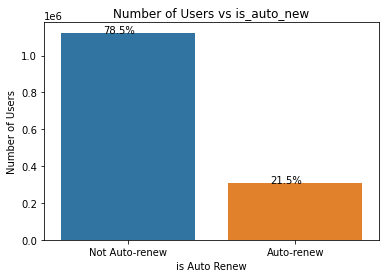

In [17]:
# countplot of number of users who have auto-renew activated and who doesn't

ax = sn.countplot(transactions_v2.is_auto_renew , order = transactions_v2.is_auto_renew.value_counts().index)
plt.xticks([0,1],['Not Auto-renew', 'Auto-renew'])
plt.xlabel("is Auto Renew")
plt.ylabel("Number of Users")
plt.title("Number of Users vs is_auto_new")

total = transactions_v2.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))


##### Only 21.5% of the users have auto-renew active.

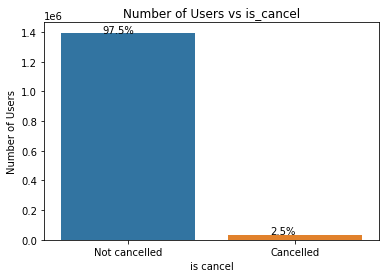

In [18]:
# countplot of number of users who have cancelled and who did not cancel their subscription

ax = sn.countplot(transactions_v2.is_cancel , order = transactions_v2.is_cancel.value_counts().index)
plt.xticks([0,1],['Not cancelled', 'Cancelled'])
plt.xlabel("is cancel")
plt.ylabel("Number of Users")
plt.title("Number of Users vs is_cancel")

total = transactions_v2.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))


##### Only 2.5 percent users had cancelled their subscriptions, which is very less

In [51]:
# calculating transactions count for each user
transaction_count_per_user = transactions_v2.groupby("msno")['msno'].count()
print(len(transaction_count_per_user))
transaction_count_per_user.head()

1197050


msno
+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=    1
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=    1
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=    2
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=    1
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=    1
Name: msno, dtype: int64

In [52]:
# converting transaction count to dataframe
transaction_count_per_user = pd.DataFrame(transaction_count_per_user)
transaction_count_per_user.columns = ['trans_count']
transaction_count_per_user.reset_index(inplace=True)
print(transaction_count_per_user.shape)
transaction_count_per_user.head()

(1197050, 2)


,msno,trans_count
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,1
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,1
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,1


In [53]:
# https://www.kaggle.com/ripcurl/feedforward-neural-network-0-12174

#keeping only latest transaction record for each user
transactions_v2 = transactions_v2.drop_duplicates(subset=['msno'], keep='first')
print(transactions_v2.shape)

(1197050, 9)


In [54]:
# dropping columns membership_expire_date, actual_amount_paid and is_cancel

transactions_v2.drop(columns=['membership_expire_date','actual_amount_paid','is_cancel'],axis=1,inplace=True)
transactions_v2.shape

(1197050, 6)

In [55]:
transactions_v2 = transactions_v2.merge(transaction_count_per_user, how='left',on='msno')

transactions_v2.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,transaction_date,trans_count
0,aKP16t82xpiU6donvP21pmmozVn6YzCGHYR2UB79/gI=,34,30,149,1,20170331,1
1,a1Cc2QvP3E0NJOAmfHoHok+/Vmd7yy1uq6XYpsaQiP0=,41,30,100,1,20170331,1
2,uCrRmrr1xrz5YF9Vt+TM2Hgc3nvW/Vw7gac+6L6c6NI=,41,30,99,1,20170331,1
3,luNHumFuvN52PF4wunvCPB2SSEqZPulWhqJ03bwvYyg=,39,30,149,1,20170331,2
4,uE5BJaui8jWgqNh6qqX5GC6mO35sQ5YgLExtV6Jyu5E=,39,30,149,1,20170331,2


In [56]:
user_logs_v2.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [57]:
# dropping duplicate rows
user_logs_v2.drop_duplicates(inplace=True)

In [58]:
# checking for missing values
user_logs_v2.isna().sum()

msno          0
date          0
num_25        0
num_50        0
num_75        0
num_985       0
num_100       0
num_unq       0
total_secs    0
dtype: int64

In [59]:
user_logs_v2.describe()

,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07
mean,2.017032e+07,6.191401e+00,1.508789e+00,9.413759e-01,1.079905e+00,3.027890e+01,2.903615e+01,7.904814e+03
std,8.916720e+00,1.342827e+01,3.908539e+00,1.924840e+00,3.518409e+00,4.132628e+01,3.219866e+01,1.013632e+04
min,2.017030e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.442900e+04,1.000000e+00,1.000000e-03
25%,2.017031e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.959944e+03
50%,2.017032e+07,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.800000e+01,4.582990e+03
75%,2.017032e+07,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.700000e+01,3.800000e+01,9.848441e+03
max,2.017033e+07,5.639000e+03,9.120000e+02,5.080000e+02,1.561000e+03,2.107300e+04,4.925000e+03,9.194059e+06


In [60]:
# checking datapoints where num_100 value is negative
user_logs_v2[user_logs_v2.num_100<0]

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
11534622,sfWgePzzK7p+HF5X/IzTitF34mnDy6LvFqHEOIvRPc4=,20170324,227,104,95,108,-24429,1510,9194058.522


In [61]:
# removing datapoints with negative value of num_100
user_logs_v2.drop(index=(user_logs_v2[user_logs_v2.num_100<0].index) ,inplace=True)

In [62]:
# converting total seconds to total minutes by dividing it by 60

user_logs_v2['total_minutes'] = user_logs_v2['total_secs']/60
user_logs_v2.drop(columns=['total_secs'],inplace=True)  # dropping column 'total_secs'

In [63]:
# taking sum of each columns for each user
user_logs_sum = user_logs_v2.groupby('msno',as_index=False).sum()
user_logs_sum.drop(columns=['date'],axis=1,inplace=True)
print(user_logs_sum.shape)
user_logs_sum.head()

(1103894, 8)


,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_minutes
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,86.0,11.0,10.0,5.0,472.0,530,1965.123750
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,191.0,90.0,75.0,144.0,589.0,885,3208.798200
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,43.0,12.0,15.0,12.0,485.0,468,1923.521000
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,207.0,163.0,100.0,64.0,436.0,828,2498.275967
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,105.0,24.0,39.0,35.0,479.0,230,1940.554117


In [64]:
# taking mean of each columns for each user
user_logs_mean = user_logs_v2.groupby('msno',as_index=False).mean()
user_logs_mean.columns = ['msno','date','mean_num_25','mean_num_50','mean_num_75','mean_num_985','mean_num_100','mean_num_unq','mean_total_min']
user_logs_mean.drop(columns=['date'],axis=1,inplace=True)
print(user_logs_mean.shape)
user_logs_mean.head()

(1103894, 8)


,msno,mean_num_25,mean_num_50,mean_num_75,mean_num_985,mean_num_100,mean_num_unq,mean_total_min
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,3.307692,0.423077,0.384615,0.192308,18.153846,20.384615,75.581683
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,6.161290,2.903226,2.419355,4.645161,19.000000,28.548387,103.509619
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.535714,0.428571,0.535714,0.428571,17.321429,16.714286,68.697179
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,9.857143,7.761905,4.761905,3.047619,20.761905,39.428571,118.965522
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,3.620690,0.827586,1.344828,1.206897,16.517241,7.931034,66.915659


In [65]:
# taking standard devaiation of each columns for each user
user_logs_std = user_logs_v2.groupby('msno').std()
user_logs_std.reset_index(inplace=True)
user_logs_std.columns = ['msno','date','std_num_25','std_num_50','std_num_75','std_num_985','std_num_100','std_num_unq','std_total_min']
user_logs_std.drop(columns=['date'],axis=1,inplace=True)
print(user_logs_std.shape)
user_logs_std.head()

(1103894, 8)


,msno,std_num_25,std_num_50,std_num_75,std_num_985,std_num_100,std_num_unq,std_total_min
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,3.056393,0.643309,0.571099,0.401918,27.874996,28.034375,107.966855
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,4.412836,2.494726,2.109885,3.271578,11.832160,13.124630,56.349687
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2.899325,0.835711,1.104943,0.741798,15.731670,12.283253,58.097147
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,9.188502,13.827164,7.112698,3.398179,17.910625,36.874885,98.317041
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,4.370467,1.226754,1.818081,1.611993,16.593072,8.202487,57.257400


In [66]:
user_logs = user_logs_sum.merge(user_logs_mean,on='msno')
user_logs = user_logs.merge(user_logs_std,on='msno')
print(user_logs.shape)
user_logs.head()

(1103894, 22)


,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_minutes,mean_num_25,mean_num_50,...,mean_num_100,mean_num_unq,mean_total_min,std_num_25,std_num_50,std_num_75,std_num_985,std_num_100,std_num_unq,std_total_min
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,86.0,11.0,10.0,5.0,472.0,530,1965.123750,3.307692,0.423077,...,18.153846,20.384615,75.581683,3.056393,0.643309,0.571099,0.401918,27.874996,28.034375,107.966855
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,191.0,90.0,75.0,144.0,589.0,885,3208.798200,6.161290,2.903226,...,19.000000,28.548387,103.509619,4.412836,2.494726,2.109885,3.271578,11.832160,13.124630,56.349687
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,43.0,12.0,15.0,12.0,485.0,468,1923.521000,1.535714,0.428571,...,17.321429,16.714286,68.697179,2.899325,0.835711,1.104943,0.741798,15.731670,12.283253,58.097147
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,207.0,163.0,100.0,64.0,436.0,828,2498.275967,9.857143,7.761905,...,20.761905,39.428571,118.965522,9.188502,13.827164,7.112698,3.398179,17.910625,36.874885,98.317041
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,105.0,24.0,39.0,35.0,479.0,230,1940.554117,3.620690,0.827586,...,16.517241,7.931034,66.915659,4.370467,1.226754,1.818081,1.611993,16.593072,8.202487,57.257400


Text(0.5, 1.0, 'Box plot of num_unq(Number of Unique songs)')

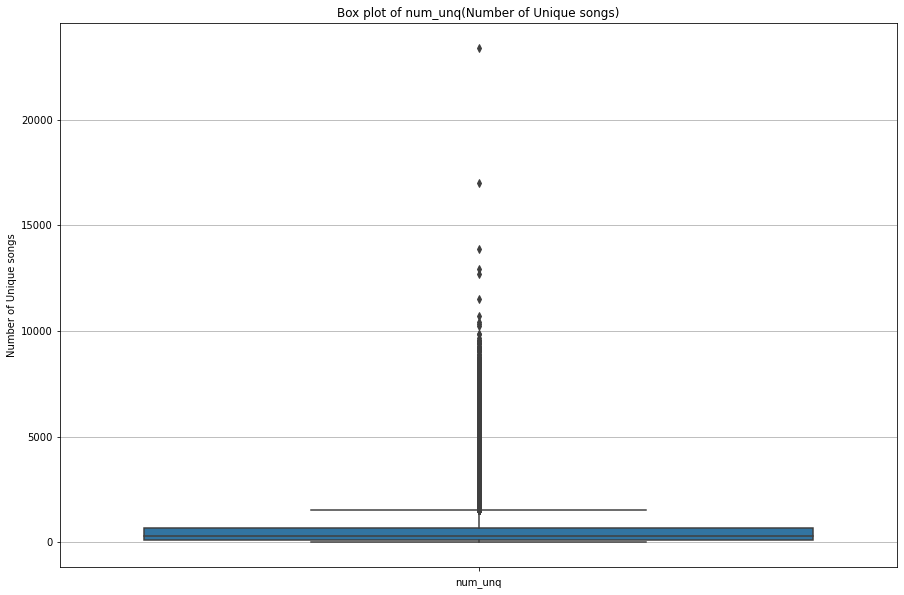

In [35]:
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(user_logs.num_unq, orient='v')
plt.xlabel("num_unq")
plt.ylabel("Number of Unique songs")
plt.title("Box plot of num_unq(Number of Unique songs)")

##### More than 90% of users have total unique number of songs less than 2500.
##### There are few users having total number of unique songs greater than 5000 and some even greater than 10000.

In [36]:
percentile(user_logs_sum,'num_unq',1,100,2)

1 percentile =  1.0
3 percentile =  2.0
5 percentile =  5.0
7 percentile =  9.0
9 percentile =  14.0
11 percentile =  20.0
13 percentile =  27.0
15 percentile =  36.0
17 percentile =  45.0
19 percentile =  55.0
21 percentile =  66.0
23 percentile =  77.0
25 percentile =  90.0
27 percentile =  103.0
29 percentile =  116.0
31 percentile =  130.0
33 percentile =  145.0
35 percentile =  161.0
37 percentile =  177.0
39 percentile =  194.0
41 percentile =  211.0
43 percentile =  229.0
45 percentile =  248.0
47 percentile =  267.0
49 percentile =  287.0
51 percentile =  308.0
53 percentile =  329.0
55 percentile =  352.0
57 percentile =  375.0
59 percentile =  399.0
61 percentile =  425.0
63 percentile =  452.0
65 percentile =  480.0
67 percentile =  511.0
69 percentile =  543.0
71 percentile =  577.0
73 percentile =  614.0
75 percentile =  653.0
77 percentile =  697.0
79 percentile =  745.0
81 percentile =  798.0
83 percentile =  857.0
85 percentile =  926.0
87 percentile =  1006.0
89 percen

In [37]:
percentile(user_logs_sum,'num_unq',99,100,.05)

99.0 percentile =  2872.0
99.05 percentile =  2918.0
99.1 percentile =  2960.0
99.14999999999999 percentile =  3006.0
99.19999999999999 percentile =  3058.8559999999125
99.24999999999999 percentile =  3112.0
99.29999999999998 percentile =  3167.0
99.34999999999998 percentile =  3225.0
99.39999999999998 percentile =  3288.0
99.44999999999997 percentile =  3359.0
99.49999999999997 percentile =  3433.5349999996834
99.54999999999997 percentile =  3521.4814999997616
99.59999999999997 percentile =  3617.0
99.64999999999996 percentile =  3719.3744999994524
99.69999999999996 percentile =  3842.0
99.74999999999996 percentile =  3987.0
99.79999999999995 percentile =  4159.0
99.84999999999995 percentile =  4381.0
99.89999999999995 percentile =  4685.213999998756
99.94999999999995 percentile =  5240.0


##### About 86% of the users have listened to a maximum of 1000 unique songs.
##### 99% of users have unqiue songs less than 5000

Text(0.5, 1.0, 'Box plot of num_25(Number of songs listened 25%)')

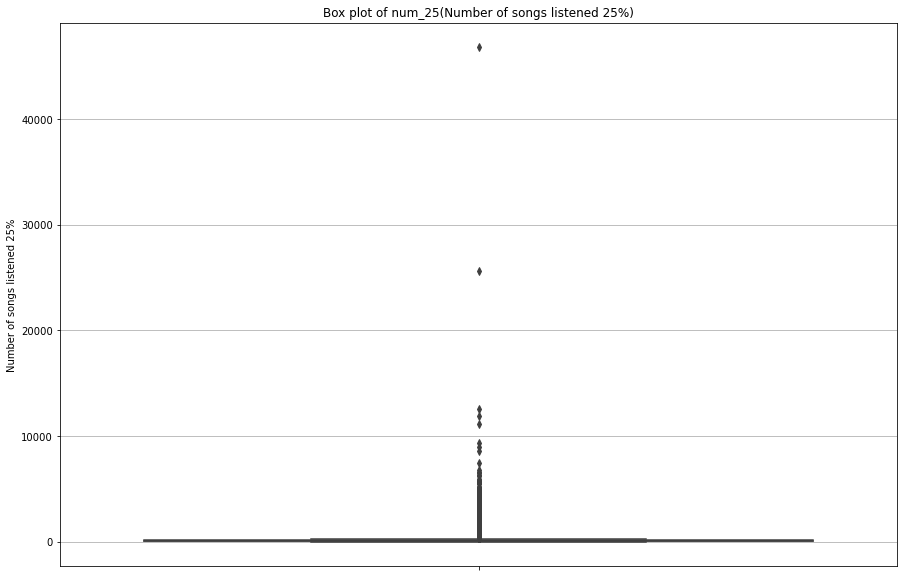

In [38]:
# box plot of num_25 i.e. number of songs listened 25% of their length
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(user_logs.num_25, orient='v')
plt.ylabel("Number of songs listened 25%")
plt.title("Box plot of num_25(Number of songs listened 25%)")

##### Can't get much info out of the above box plot. But it seems there are very less users who played songs less than 25% of the song length

Text(0.5, 1.0, 'Box plot of num_50(Number of songs listened 50%)')

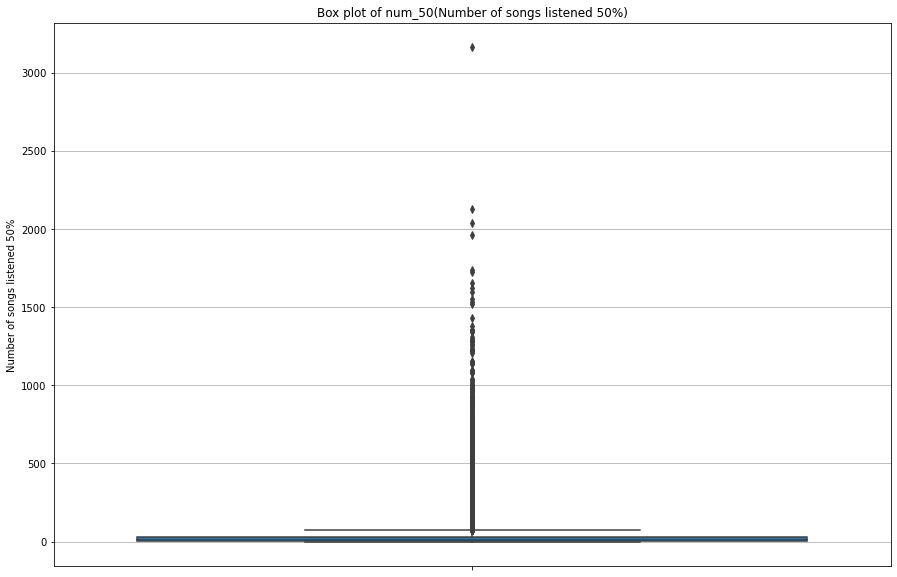

In [39]:
# box plot of num_50 i.e. number of songs listened 50% of their length
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(user_logs.num_50, orient='v')
plt.ylabel("Number of songs listened 50%")
plt.title("Box plot of num_50(Number of songs listened 50%)")

##### More than 80% of the users have number of songs below 200, that are played between 25% to 50% of the song length

Text(0.5, 1.0, 'Box plot of num_75(Number of songs listened 75%)')

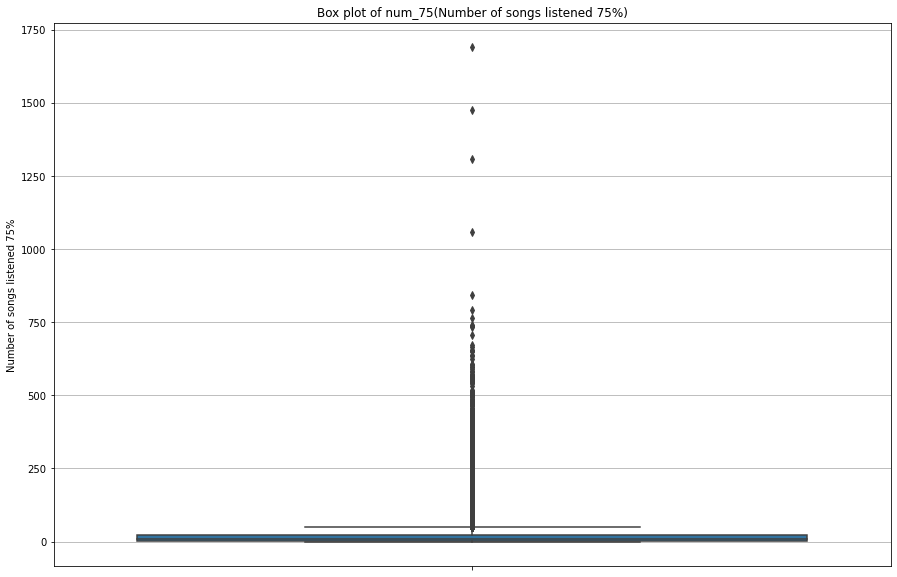

In [40]:
# box plot of num_75 i.e. number of songs listened 75% of their length
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(user_logs.num_75, orient='v')
plt.ylabel("Number of songs listened 75%")
plt.title("Box plot of num_75(Number of songs listened 75%)")

##### 90% of the users have songs(that are played between 50% to 75% of of the song length) less than 250 

Text(0.5, 1.0, 'Box plot of num_985(Number of songs listened 985%)')

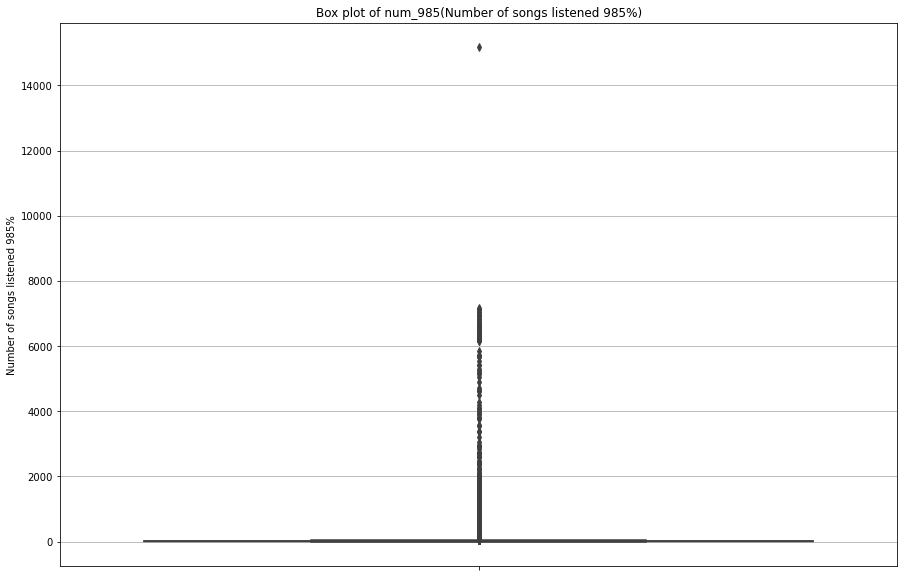

In [41]:
# box plot of num_985 i.e. number of songs listened 98.5% of their length
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(user_logs.num_985, orient='v')
plt.ylabel("Number of songs listened 985%")
plt.title("Box plot of num_985(Number of songs listened 985%)")

##### Not getting enough info out of it

Text(0.5, 1.0, 'Box plot of Total minutes listened')

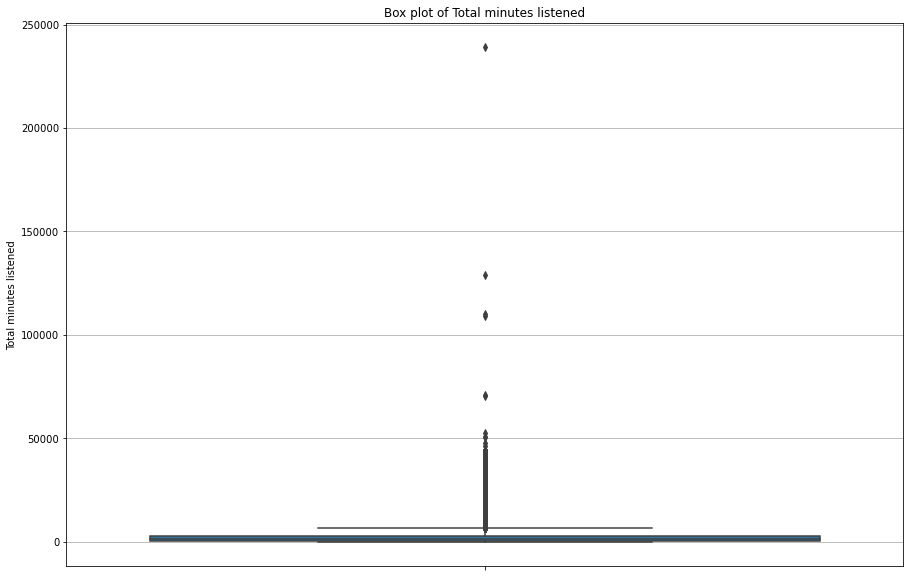

In [42]:
# box plot of total minutes listened by a user
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(user_logs.total_minutes, orient='v')
plt.ylabel("Total minutes listened")
plt.title("Box plot of Total minutes listened")

Plot shows that most of the users have listened upto total 5000 minutes

In [43]:
percentile(user_logs,'total_minutes',1,100,2)

1 percentile =  1.3522716666666665
3 percentile =  5.2017695
5 percentile =  12.9360925
7 percentile =  26.127631500000003
9 percentile =  45.86785183333333
11 percentile =  70.12502549999999
13 percentile =  98.92098916666666
15 percentile =  132.19183166666664
17 percentile =  169.81308133333334
19 percentile =  211.04253933333337
21 percentile =  256.6458171666667
23 percentile =  304.7570931666667
25 percentile =  355.5785041666667
27 percentile =  409.6035258333334
29 percentile =  466.6937484999999
31 percentile =  526.5429741666667
33 percentile =  588.7749615
35 percentile =  653.6273458333333
37 percentile =  721.641455
39 percentile =  791.7572048333335
41 percentile =  865.0773163333333
43 percentile =  941.1777719999999
45 percentile =  1020.1848433333333
47 percentile =  1102.2012458333331
49 percentile =  1187.0761573333332
51 percentile =  1275.1454006666668
53 percentile =  1366.052677666667
55 percentile =  1461.6521883333335
57 percentile =  1562.0418146666666
59 perc

In [44]:
percentile(user_logs,'total_minutes',98,100,0.2)

98.0 percentile =  11881.643410666664
98.2 percentile =  12394.3563721
98.4 percentile =  12979.520688000015
98.60000000000001 percentile =  13639.437017700016
98.80000000000001 percentile =  14373.521650400071
99.00000000000001 percentile =  15272.586951666675
99.20000000000002 percentile =  16328.458029066695
99.40000000000002 percentile =  17684.319803766844
99.60000000000002 percentile =  19452.065948600037
99.80000000000003 percentile =  22571.66992240002


##### 90%  of the users have listened number of minutes upto 5000


In [67]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [68]:
members.drop_duplicates(inplace=True)

In [69]:
members.isna().sum()

msno                            0
city                            0
bd                              0
gender                    4429505
registered_via                  0
registration_init_time          0
dtype: int64

In [70]:
members.fillna("NP",inplace=True) # filling NaN in Gender column with "NP" i.e. Not Provided

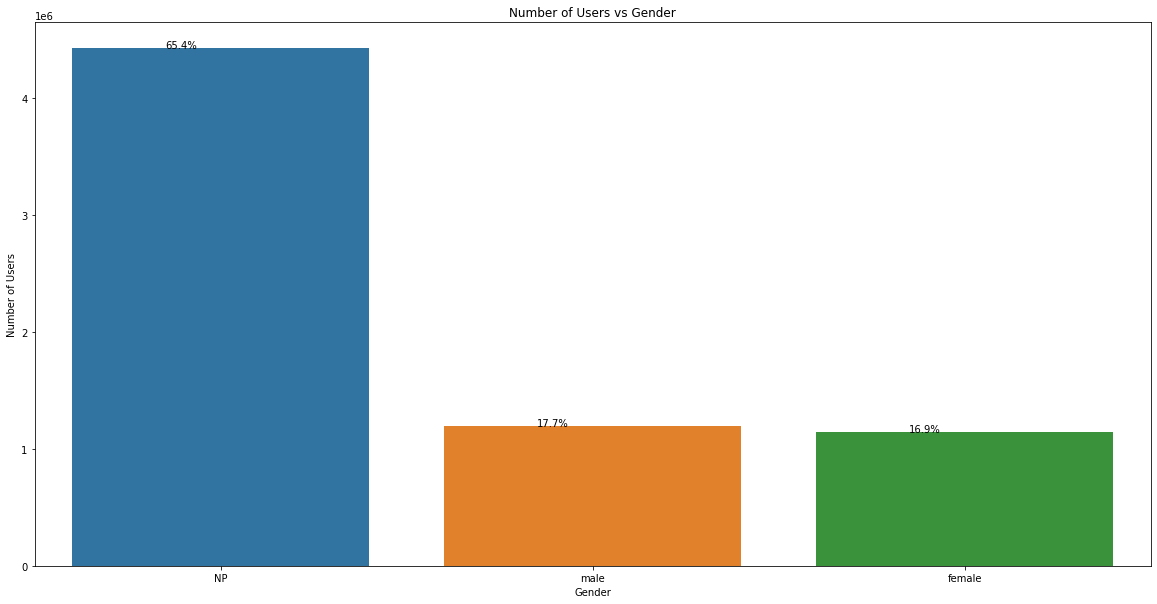

In [71]:
#plot of gender vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(members.gender, order=members.gender.value_counts().index)
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Number of Users vs Gender")

total = members.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### 65.4% of the user's gender details are not present, 17.7% users are male, 16.9% users are female.
##### As most of values in gender are NULL, so I would drop this column

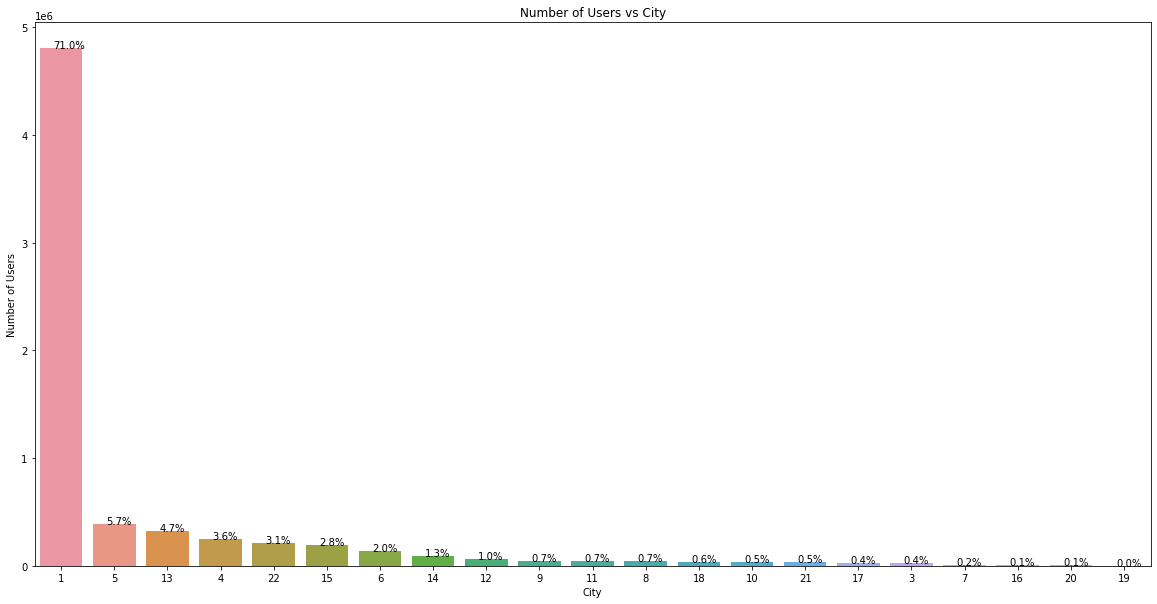

In [50]:
#plot of city vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(members.city, order=members.city.value_counts().index)
plt.xlabel("City")
plt.ylabel("Number of Users")
plt.title("Number of Users vs City")

total = members.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### 71% of the users are from city '1'. 
##### Other cities have very less number of users.

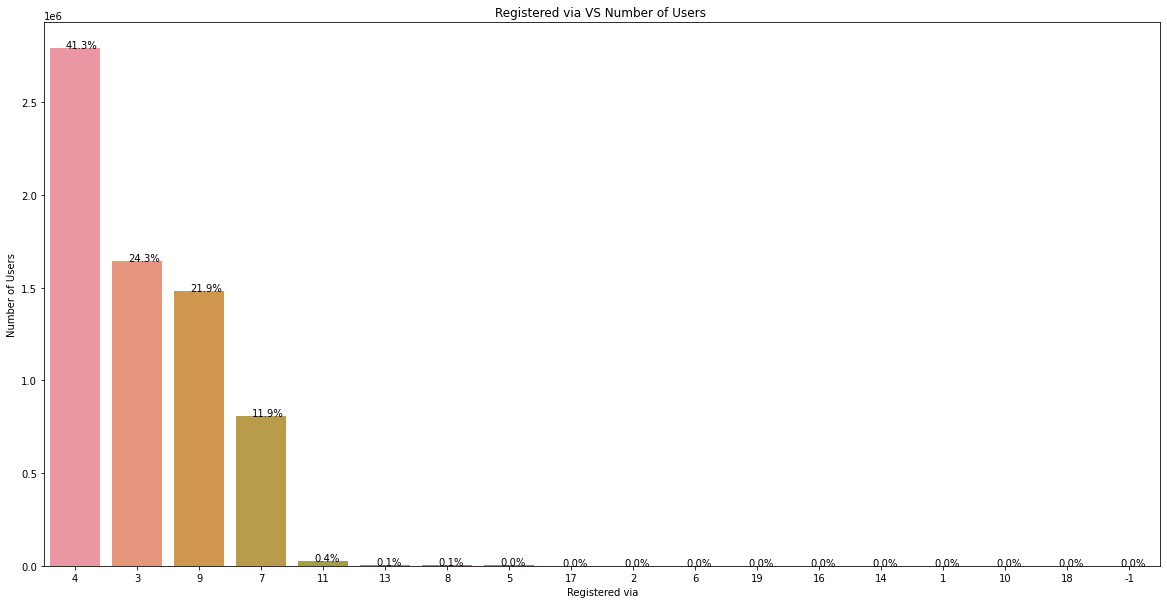

In [51]:
#plot of registered_via vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(members.registered_via, order=members.registered_via.value_counts().index)
plt.xlabel("Registered via")
plt.ylabel("Number of Users")
plt.title("Registered via VS Number of Users ")

total = members.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### 41.3 % users are registered via '4'. 
##### 24.3% users are registered via '3'. 
##### 21.9% users are registered via '9'.
##### 11.9% users are registered via '7'.
##### Other 'registered_via' don't have much users

### Merging all dataframes - transactions, trainv2, members, user_logs

In [72]:
train = trainv2.merge(transactions_v2,how='left',on='msno')

members.drop(columns=['registration_init_time','gender'],axis=1,inplace=True)  # dropping 'gender' column as 65% values are NULL
train = train.merge(members,how='left',on='msno')  

train = train.merge(user_logs,how='left',on='msno')

print(train.shape)
train.head()

(970960, 32)


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,transaction_date,trans_count,city,bd,...,mean_num_100,mean_num_unq,mean_total_min,std_num_25,std_num_50,std_num_75,std_num_985,std_num_100,std_num_unq,std_total_min
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,NaN,NaN,NaN,NaN,NaN,NaN,5.0,28.0,...,28.909091,31.636364,122.119026,40.458508,5.629468,2.136267,1.640399,27.678347,45.193523,107.973295
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36.0,30.0,180.0,0.0,20170311.0,1.0,13.0,20.0,...,4.333333,5.000000,19.406969,0.000000,1.211060,0.516398,0.000000,3.204164,3.162278,13.536397
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15.0,90.0,300.0,0.0,20170314.0,2.0,13.0,18.0,...,10.250000,21.600000,56.508722,15.435690,2.661124,1.569445,1.586124,13.234226,24.327589,66.384507
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41.0,30.0,149.0,1.0,20151208.0,10.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,41.0,30.0,99.0,1.0,20170316.0,8.0,13.0,35.0,...,64.133333,36.533333,266.535823,0.736788,0.833809,0.457738,0.457738,37.228765,15.070627,153.289255


In [73]:
# checking proportion of missing values in each column
train.isna().sum()/train.shape[0]

msno                 0.000000
is_churn             0.000000
payment_method_id    0.038500
payment_plan_days    0.038500
plan_list_price      0.038500
is_auto_renew        0.038500
transaction_date     0.038500
trans_count          0.038500
city                 0.113283
bd                   0.113283
registered_via       0.113283
num_25               0.222881
num_50               0.222881
num_75               0.222881
num_985              0.222881
num_100              0.222881
num_unq              0.222881
total_minutes        0.222881
mean_num_25          0.222881
mean_num_50          0.222881
mean_num_75          0.222881
mean_num_985         0.222881
mean_num_100         0.222881
mean_num_unq         0.222881
mean_total_min       0.222881
std_num_25           0.252046
std_num_50           0.252046
std_num_75           0.252046
std_num_985          0.252046
std_num_100          0.252046
std_num_unq          0.252046
std_total_min        0.252046
dtype: float64

As there are 25.2% of values are NULL for the following features - `std_num_25, std_num_50, std_num_75, std_num_985, std_num_100, std_num_unq, std_total_min`. So I would drop these features.

In [144]:
# dropping std dev features
train.drop(columns=['std_num_25', 'std_num_50', 'std_num_75', 'std_num_985', 'std_num_100', 'std_num_unq', 'std_total_min'],axis=1,inplace=True)

In [145]:
numerical_columns = ['payment_plan_days','plan_list_price','num_25', 'num_50', 'num_75', 'num_985', 'num_100',
                     'num_unq', 'total_minutes', 'mean_num_25', 'mean_num_50', 'mean_num_75','mean_num_985', 
                     'mean_num_100', 'mean_num_unq', 'mean_total_min','bd','trans_count']
    
categorical_columns = ['payment_method_id','is_auto_renew','city','registered_via','transaction_date']

In [146]:
# function to get mean values for all numerical features
def get_mean(data,numerical_columns):
    
    mean_dict = dict()
    
    for column in numerical_columns:
        
        mean_dict[column] = np.mean(data[column])
        
    return mean_dict

#=================================================================

# function to get median values for all numerical features
def get_median(data,numerical_columns):
    
    median_dict = dict()
    
    for column in numerical_columns:
        
        median_dict[column] = np.nanmedian(data[column])
        
    return median_dict

#=================================================================


# function to get mode values for all categorical features
def get_mode(data,categorical_columns):
    
    mode_dict = dict()
    
    for column in categorical_columns:
        
        mode_dict[column] = data[column].value_counts().index[0]
        
    return mode_dict
    

In [147]:
# getting mean and mode values from train data

train_data_mean = get_mean(train,numerical_columns)
train_data_median = get_median(train,numerical_columns)
train_data_mode = get_mode(train,categorical_columns)

print("Mean values from train data:",train_data_mean)
print("="*50)
print("Median values from train data:",train_data_median)
print("="*50)
print("Mode values from train data:",train_data_mode)

Mean values from train data: {'payment_plan_days': 33.89941065449271, 'plan_list_price': 145.06755943263445, 'num_25': 108.77378599988603, 'num_50': 26.257260277966633, 'num_75': 16.545723218178757, 'num_985': 18.71342029895925, 'num_100': 535.9022518027277, 'num_unq': 511.8789346246973, 'total_minutes': 2329.740138687545, 'mean_num_25': 5.371599642081597, 'mean_num_50': 1.311821782746147, 'mean_num_75': 0.8033237666675522, 'mean_num_985': 0.886026200275259, 'mean_num_100': 24.673040757142353, 'mean_num_unq': 24.32385910804637, 'mean_total_min': 107.8618417816259, 'bd': 13.583853968851303, 'trans_count': 1.2125778456647436}
Median values from train data: {'payment_plan_days': 30.0, 'plan_list_price': 149.0, 'num_25': 55.0, 'num_50': 14.0, 'num_75': 10.0, 'num_985': 10.0, 'num_100': 305.0, 'num_unq': 330.0, 'total_minutes': 1377.3373333333332, 'mean_num_25': 3.4545454545454546, 'mean_num_50': 0.8888888888888888, 'mean_num_75': 0.6, 'mean_num_985': 0.6086956521739131, 'mean_num_100': 17.

In [148]:
# https://www.kaggle.com/hjsdssz/kkbox-churn-prediction-model 

# function to fill NULL values of numerical features with mean

def fill_with_mean(data,numerical_columns):
    
    for column in numerical_columns:
        data[column].fillna(train_data_mean[column],inplace=True)
        
#===============================================================================

# function to fill NULL values of numerical features with mean

def fill_with_median(data,numerical_columns):
    
    for column in numerical_columns:
        data[column].fillna(train_data_median[column],inplace=True)

#===============================================================================

# function to fill NULL values of categorical features with most occuring values 

def fill_with_mode(data,categorical_columns): 
    
    for column in categorical_columns:
        data[column].fillna(train_data_mode[column], inplace=True)

In [149]:
# filling missing numerical values with median
fill_with_median(train,numerical_columns)

# filling missing categorical values and missing date with mode
fill_with_mode(train,categorical_columns)

In [150]:
train.isna().sum()

msno                 0
is_churn             0
payment_method_id    0
payment_plan_days    0
plan_list_price      0
is_auto_renew        0
transaction_date     0
trans_count          0
city                 0
bd                   0
registered_via       0
num_25               0
num_50               0
num_75               0
num_985              0
num_100              0
num_unq              0
total_minutes        0
mean_num_25          0
mean_num_50          0
mean_num_75          0
mean_num_985         0
mean_num_100         0
mean_num_unq         0
mean_total_min       0
dtype: int64

Text(0.5, 1.0, 'Box plot of Payment Plan Days')

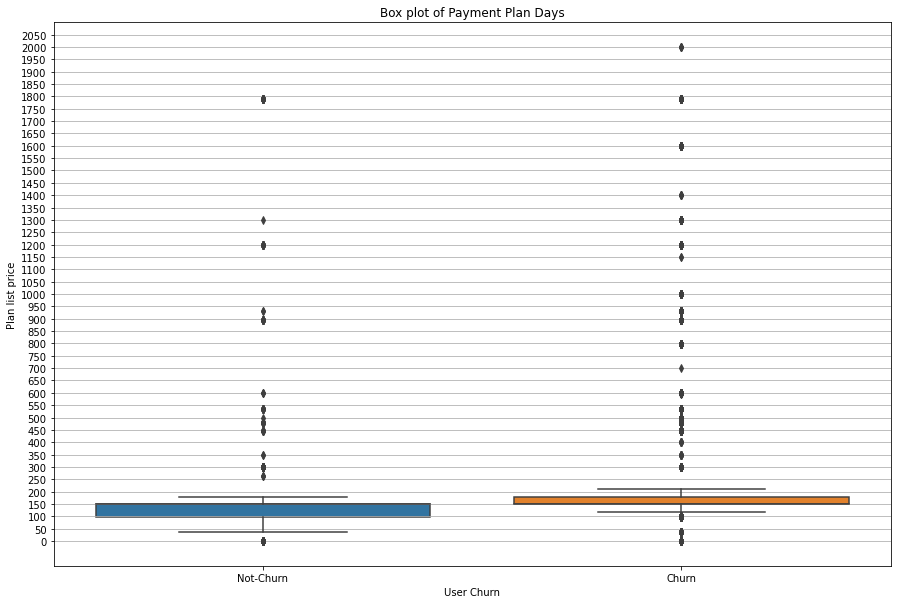

In [61]:

# BoxPlot of plan_list_price for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.plan_list_price, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
ymax=np.max(train.plan_list_price)
plt.yticks(np.arange(0,ymax+100,50))
plt.xlabel("User Churn")
plt.ylabel("Plan list price")
plt.title("Box plot of Payment Plan Days")


##### For Churned users, most of the plan price lies between 100 to 220.
##### For not-churned users, most of the plan price lies between 50 to 180.
##### There are many churned users who have plan price more than 250.
##### So the users with higher plan price are more likely to churn.

Text(0.5, 1.0, 'Number of users vs Age')

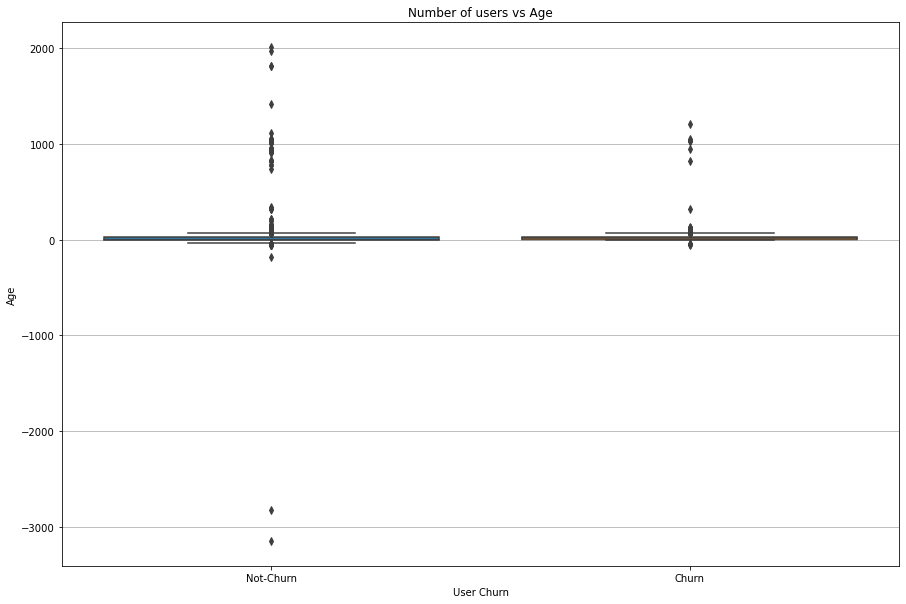

In [62]:
# BoxPlot of age for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.bd, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Age")
plt.title("Number of users vs Age")

As there are many outliers in the age feature that are negative as well as more than 100, and also the age for churned and not-churned users are too much overlapping so I would drop the 'age' feature.

In [154]:
train.drop(columns='bd',axis=1,inplace=True)
train.shape

(970960, 28)

Text(0.5, 1.0, 'Number of users vs Number of transactions')

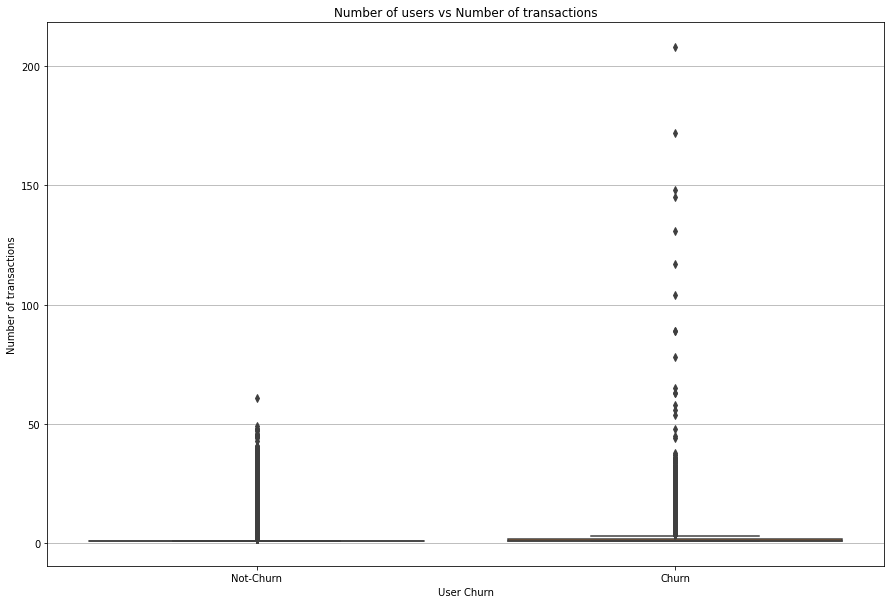

In [64]:
# BoxPlot of age for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.trans_count, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Number of transactions")
plt.title("Number of users vs Number of transactions")

##### The above box plot shows that both churned and not-churned users have number of transactions less than 50. 
##### Most of the users who have number of transactions greater than 50 have churned

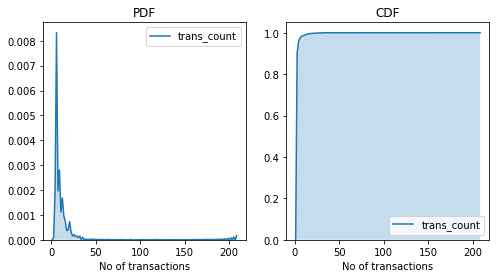

In [66]:
# kde plot of number of transactions of chunred users
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['trans_count'], shade=True, ax=ax1)
plt.xlabel('No of transactions')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['trans_count'], shade=True, cumulative=True, ax=ax2)
#cdf(no_of_rated_movies_per_user)
plt.xlabel('No of transactions')
plt.title('CDF')

plt.show()


It seems most of the churned users have number of transactions less than 50, but there are few users who have greater than 50 as well as 200.

In [151]:
# creating new features out of registration date 

# taking just day of month
train['day_of_month'] = train.transaction_date.apply(lambda x: np.int8(str(int(x))[6:]))

# taking removing year from the date and taking just month and day of month 
train['month_day'] = train.transaction_date.apply(lambda x: np.int16(str(int(x))[4:]))

# 'day_of_week' signifies which day of week it is. 
# e.g.  Monday is 1 and Sunday is 7
train['day_of_week'] = train.transaction_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").isoweekday())

# creating a feature 'is_weekend' which is '1' if the registration date is weekend i.e. Saturday or Sunday, else '0'
train['is_weekend'] = train.day_of_week.map(lambda x:1 if x in (6,7) else 0)

In [155]:
print(train.shape)
train.head()

(970960, 28)


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,transaction_date,trans_count,city,registered_via,...,mean_num_50,mean_num_75,mean_num_985,mean_num_100,mean_num_unq,mean_total_min,day_of_month,month_day,day_of_week,is_weekend
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,41.0,30.0,149.0,1.0,20170331.0,1.0,5.0,3.0,...,2.090909,1.181818,0.909091,28.909091,31.636364,122.119026,31,331,5,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36.0,30.0,180.0,0.0,20170311.0,1.0,13.0,3.0,...,0.666667,0.333333,0.000000,4.333333,5.000000,19.406969,11,311,6,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15.0,90.0,300.0,0.0,20170314.0,2.0,13.0,3.0,...,2.850000,1.600000,1.100000,10.250000,21.600000,56.508722,14,314,2,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41.0,30.0,149.0,1.0,20151208.0,10.0,1.0,7.0,...,0.888889,0.600000,0.608696,17.454545,19.233333,78.483853,8,1208,2,0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,41.0,30.0,99.0,1.0,20170316.0,8.0,13.0,7.0,...,0.466667,0.266667,0.266667,64.133333,36.533333,266.535823,16,316,4,0


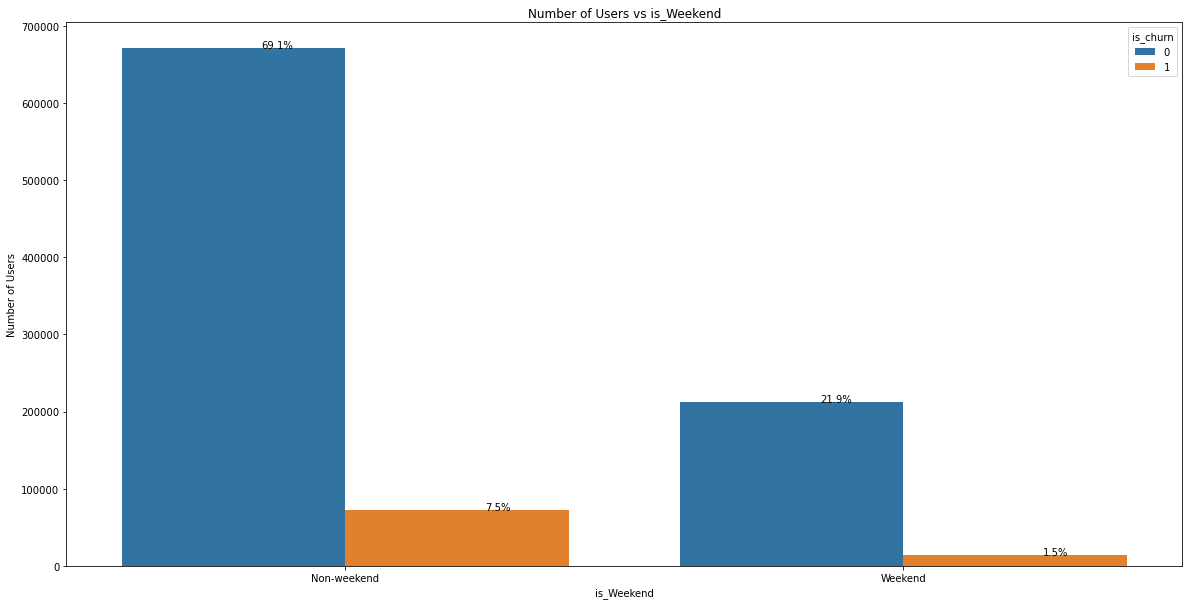

In [69]:
#plot of weekend vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(train.is_weekend, hue=train.is_churn,order=train.is_weekend.value_counts().index)
plt.xticks([1,0],['Weekend','Non-weekend'])
plt.xlabel("is_Weekend")
plt.ylabel("Number of Users")
plt.title("Number of Users vs is_Weekend")

total = train.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### 76.5% of the total users subscribed on non-weekend i.e.  between Monday-Friday.
##### Users who subscribed on weekend and churned are 1.5%, users who subscribed on non-weekend and churned are 7.5%, which is almost 5 times. So users subscribed between Monday-Friday are more likely to churn.

Note: Here non-weekend means Monday-Friday

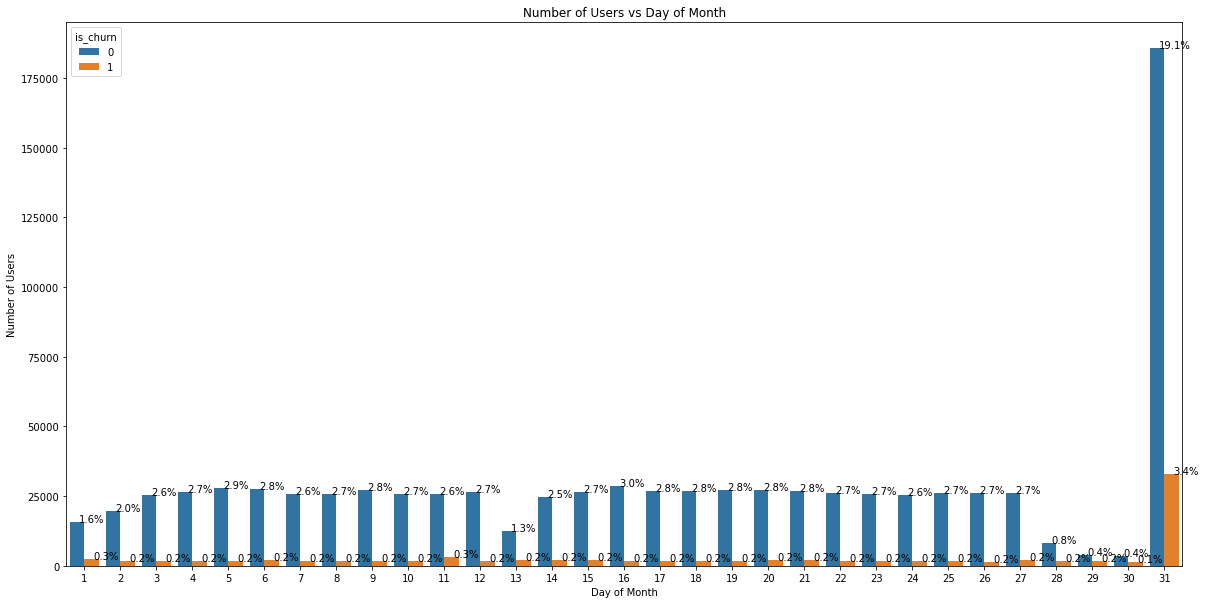

In [70]:

#plot of day_of_month vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(train.day_of_month, hue=train.is_churn)
plt.xlabel("Day of Month")
plt.ylabel("Number of Users")
plt.title("Number of Users vs Day of Month")

total = train.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

##### Above plot shows that maximum number of users (around 22%) have registered on 31st day of month. All other days are mostly same, except 28th-30th days, which have very less registrations somewhere between 0.5 - 1% each day

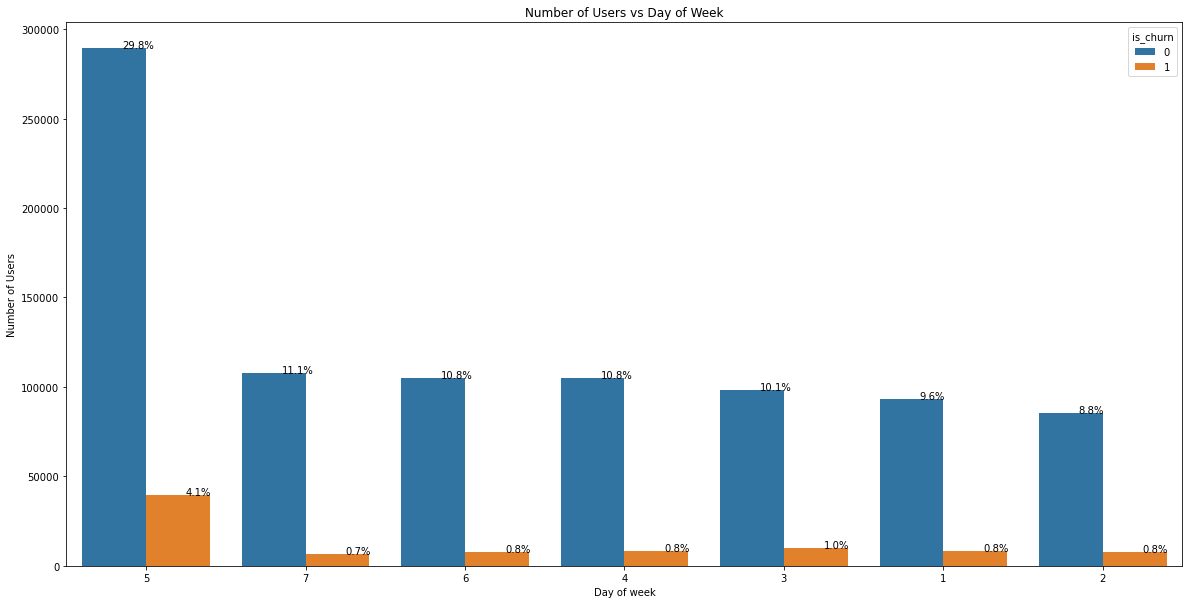

In [71]:

#plot of day_of_week vs number of users 
plt.figure(figsize=(20,10))
ax = sn.countplot(train.day_of_week, hue=train.is_churn, order=train.day_of_week.value_counts().index)
plt.xlabel("Day of week")
plt.ylabel("Number of Users")
plt.title("Number of Users vs Day of Week")

total = train.shape[0]

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()))

plt.show()

#####  5th days of week i.e. Friday have maximum number of subscriptions. Around 34% users subscribed on Friday.
##### Other days of week have similar number of registrations (around 10-12% each day)

In [72]:
train.columns

Index(['msno', 'is_churn', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'is_auto_renew', 'transaction_date', 'trans_count',
       'city', 'registered_via', 'num_25', 'num_50', 'num_75', 'num_985',
       'num_100', 'num_unq', 'total_minutes', 'mean_num_25', 'mean_num_50',
       'mean_num_75', 'mean_num_985', 'mean_num_100', 'mean_num_unq',
       'mean_total_min', 'day_of_month', 'month_day', 'day_of_week',
       'is_weekend'],
      dtype='object')

In [156]:
# creating a new feature - min_per_song i.e. average minutes listened per song

train['min_per_song'] = train['total_minutes']/(train['num_25']+train['num_50']+train['num_75']+train['num_985']+train['num_100'])

# creating a new feature - avg_min_per_unq i.e. average minutes listened per unique song

train['avg_min_per_unq'] = train['mean_total_min']/train['mean_num_unq']

#========================================================================================================

# creating a feature 'total_num' i.e. total number of songs listened by the user
train['total_num'] = train['num_25']+train['num_50']+train['num_75']+train['num_985']+train['num_100']

# creating a feature 'ratio_num_25' i.e. ratio of 'total_num'(total number of songs) and 'num_25'(number of songs listened upto 25% of their length)
# train['ratio_num_25'] = [train['total_num'][i]/train['num_25'][i] for i in range(train.shape[0])]
train['ratio_num_25'] = train['num_25']/train['total_num']

# creating a feature 'ratio_num_50' i.e. ratio of 'total_num'(total number of songs) and 'num_50'(number of songs listened upto 50% of their length)
train['ratio_num_50'] = train['num_50']/train['total_num']

# creating a feature 'ratio_num_75' i.e. ratio of 'total_num'(total number of songs) and 'num_75'(number of songs listened upto 75% of their length)
train['ratio_num_75'] = train['num_75']/train['total_num']

# creating a feature 'ratio_num_985' i.e. ratio of 'total_num'(total number of songs) and 'num_985'(number of songs listened upto 98.5% of their length)
train['ratio_num_985'] = train['num_985']/train['total_num']

# creating a feature 'ratio_num_100' i.e. ratio of 'total_num'(total number of songs) and 'num_100'(number of songs listened upto 100% of their length)
train['ratio_num_100'] = train['num_100']/train['total_num']

# creating a feature 'total_by_unq' i.e. total_num divided by num_unq
train['total_by_unq'] = train['total_num']/train['num_unq']


In [157]:
train.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,transaction_date,trans_count,city,registered_via,...,is_weekend,min_per_song,avg_min_per_unq,total_num,ratio_num_25,ratio_num_50,ratio_num_75,ratio_num_985,ratio_num_100,total_by_unq
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,41.0,30.0,149.0,1.0,20170331.0,1.0,5.0,3.0,...,0,2.442381,3.860084,550.0,0.338182,0.041818,0.023636,0.018182,0.578182,1.580460
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36.0,30.0,180.0,0.0,20170311.0,1.0,13.0,3.0,...,1,3.638807,3.881394,32.0,0.000000,0.125000,0.062500,0.000000,0.812500,1.066667
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15.0,90.0,300.0,0.0,20170314.0,2.0,13.0,3.0,...,0,2.036350,2.616145,555.0,0.430631,0.102703,0.057658,0.039640,0.369369,1.284722
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41.0,30.0,149.0,1.0,20151208.0,10.0,1.0,7.0,...,0,3.495780,4.080616,394.0,0.139594,0.035533,0.025381,0.025381,0.774112,1.193939
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,41.0,30.0,99.0,1.0,20170316.0,8.0,13.0,7.0,...,0,4.054805,7.295689,986.0,0.009128,0.007099,0.004057,0.004057,0.975659,1.799270


In [158]:
train.columns

Index(['msno', 'is_churn', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'is_auto_renew', 'transaction_date', 'trans_count',
       'city', 'registered_via', 'num_25', 'num_50', 'num_75', 'num_985',
       'num_100', 'num_unq', 'total_minutes', 'mean_num_25', 'mean_num_50',
       'mean_num_75', 'mean_num_985', 'mean_num_100', 'mean_num_unq',
       'mean_total_min', 'day_of_month', 'month_day', 'day_of_week',
       'is_weekend', 'min_per_song', 'avg_min_per_unq', 'total_num',
       'ratio_num_25', 'ratio_num_50', 'ratio_num_75', 'ratio_num_985',
       'ratio_num_100', 'total_by_unq'],
      dtype='object')

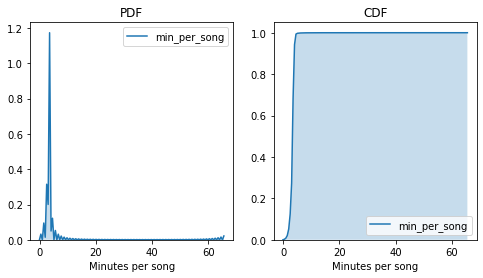

In [77]:
## kde plot of minutes listened per song by users who did not churn
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['min_per_song'], shade=True, ax=ax1)
plt.xlabel('Minutes per song')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['min_per_song'], shade=True, cumulative=True, ax=ax2)
#cdf(no_of_rated_movies_per_user)
plt.xlabel('Minutes per song')
plt.title('CDF')

plt.show()


Most of the Churned users have minutes per song upto 20. But there are users who have values more than 60

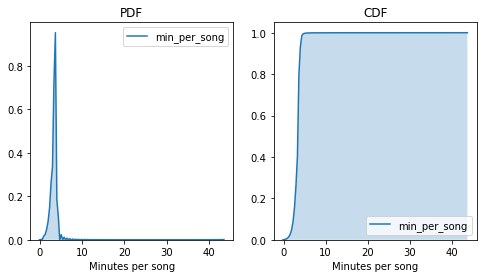

In [78]:
## kde plot of minutes listened per song by churned users
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['min_per_song'], shade=True, ax=ax1)
plt.xlabel('Minutes per song')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['min_per_song'], shade=True, cumulative=True, ax=ax2)
#cdf(no_of_rated_movies_per_user)
plt.xlabel('Minutes per song')
plt.title('CDF')

plt.show()


Most of the Churned users have minutes per song less than 10. But there are users who have values upto 40

Text(0.5, 1.0, 'Users vs Minutes per song')

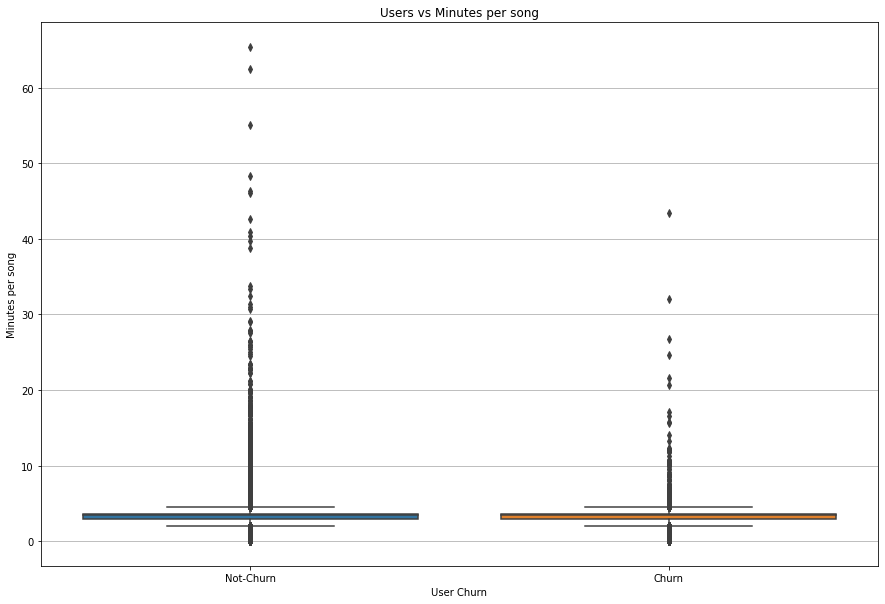

In [79]:
# BoxPlot of min_per_song for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.min_per_song, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Minutes per song")
plt.title("Users vs Minutes per song")

Churned users have lesser minutes per song compared to not-churned users

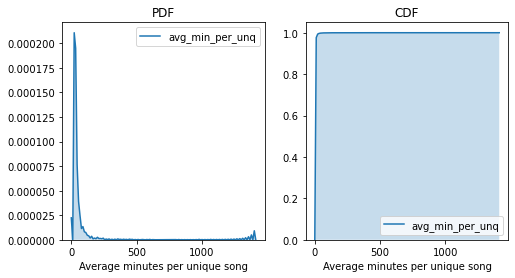

In [81]:
## kde plot of average minutes listened per unique song by users who did not churn
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['avg_min_per_unq'], shade=True, ax=ax1)
plt.xlabel('Average minutes per unique song')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['avg_min_per_unq'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Average minutes per unique song')
plt.title('CDF')

plt.show()


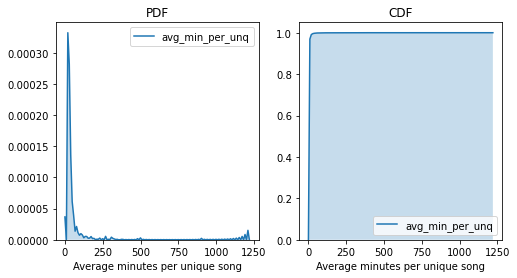

In [82]:
## kde plot of average minutes listened per unique song by users who churned
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['avg_min_per_unq'], shade=True, ax=ax1)
plt.xlabel('Average minutes per unique song')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['avg_min_per_unq'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Average minutes per unique song')
plt.title('CDF')

plt.show()


Text(0.5, 1.0, 'Users vs Average minutes per unique song')

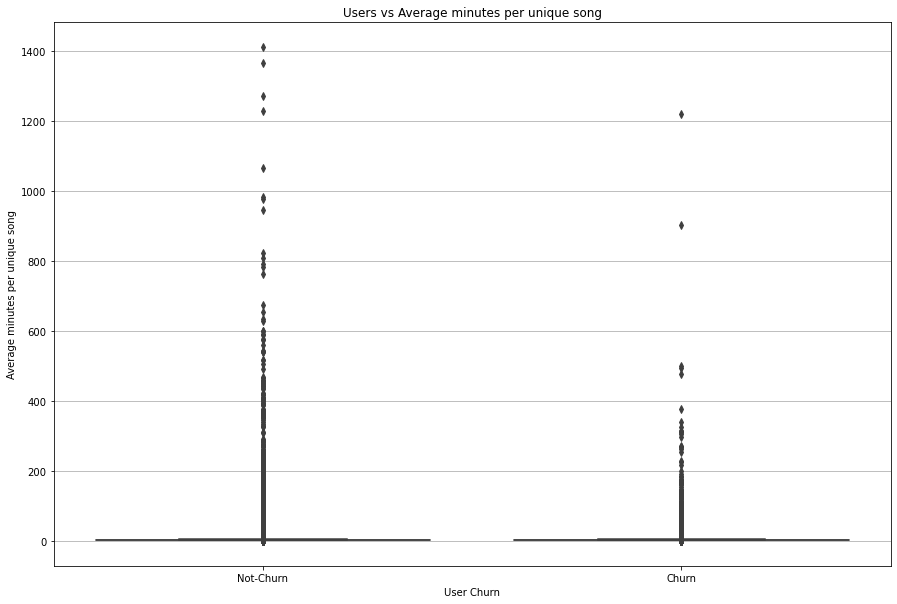

In [83]:
# BoxPlot of Average minutes per unique song churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.avg_min_per_unq, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Average minutes per unique song")
plt.title("Users vs Average minutes per unique song")

The users who did not churn, have higher average minute per unique song compared to the churned users.
For not-churned users, there are many values greater than 400, but for churned users almost all values are upto 400.

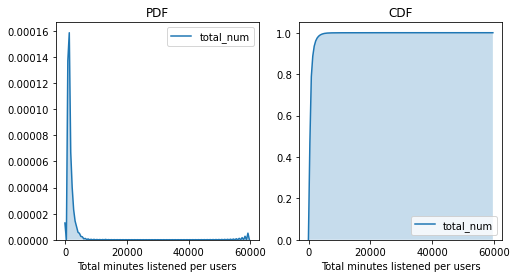

In [84]:
## kde plot of average minutes listened per unique song by users who did not churn
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['total_num'], shade=True, ax=ax1)
plt.xlabel('Total minutes listened per users')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['total_num'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Total minutes listened per users')
plt.title('CDF')

plt.show()


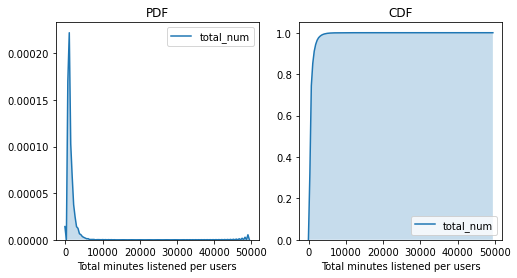

In [85]:
## kde plot of average minutes listened per unique song by users who churned
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['total_num'], shade=True, ax=ax1)
plt.xlabel('Total minutes listened per users')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['total_num'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Total minutes listened per users')
plt.title('CDF')

plt.show()


Text(0.5, 1.0, 'Users vs Total minutes listened by users')

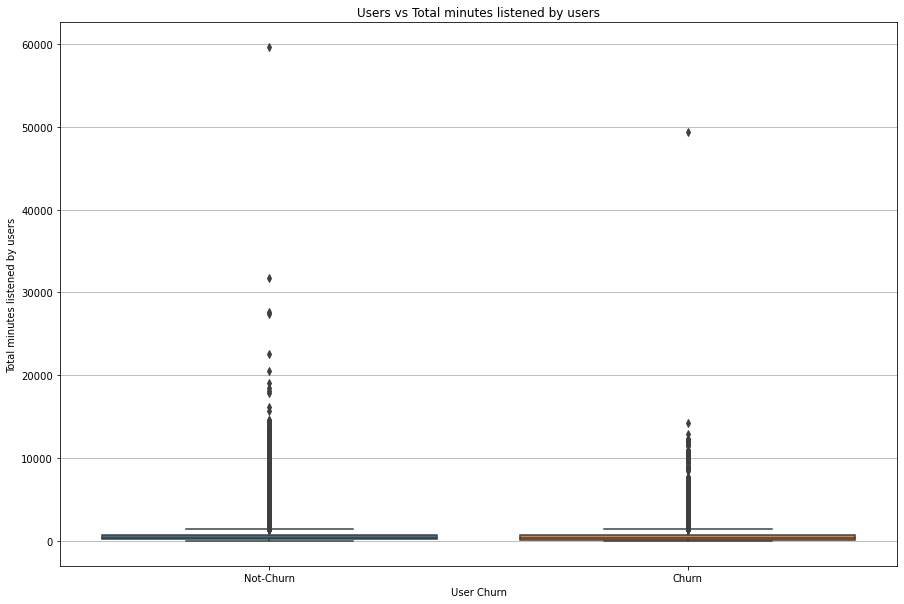

In [86]:
# BoxPlot of Average minutes per unique song for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.total_num, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Total minutes listened by users")
plt.title("Users vs Total minutes listened by users")

Total mins for both churn and not-churn users are overlapping, but there are very few not-chunred users who have higher total minutes than churned users.

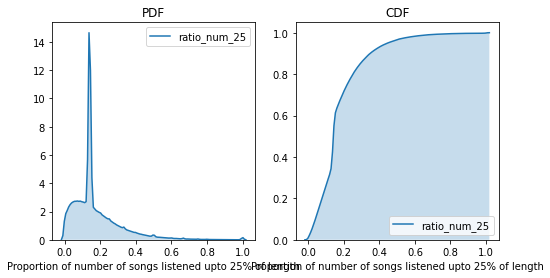

In [87]:
## kde plot of ratio_num_25 for users who did not churn
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['ratio_num_25'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 25% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['ratio_num_25'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Average minutes per unique song')
plt.title('CDF')

plt.show()


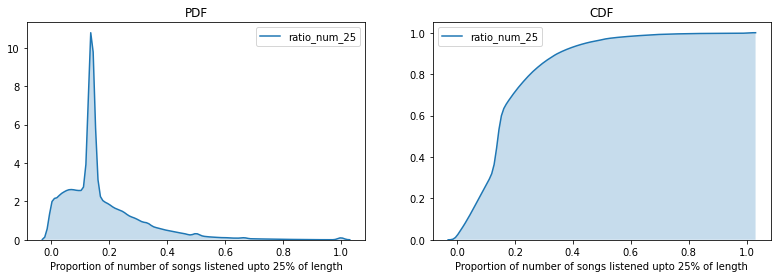

In [91]:
## kde plot of ratio_num_25 for users who churned
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['ratio_num_25'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 25% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['ratio_num_25'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 25% of length')
plt.title('CDF')

plt.show()


Text(0.5, 1.0, 'Users vs Proportion of number of songs listened upto 25% of length')

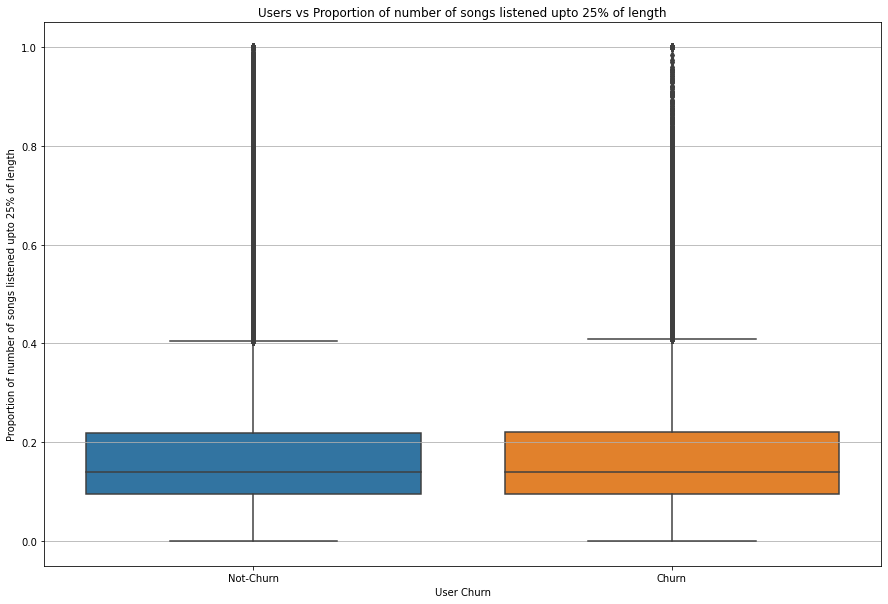

In [95]:
# BoxPlot of ratio_num_25 for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.ratio_num_25, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Proportion of number of songs listened upto 25% of length")
plt.title("Users vs Proportion of number of songs listened upto 25% of length")

For both churned and not-churned users, ratio_num_25 is almost overlapping.

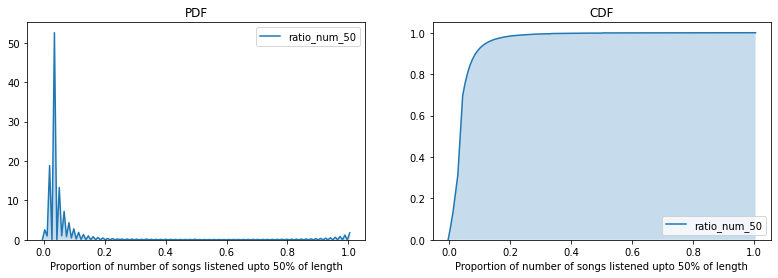

In [94]:
## kde plot of ratio_num_50 for users who did not churn
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['ratio_num_50'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 50% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['ratio_num_50'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 50% of length')
plt.title('CDF')

plt.show()


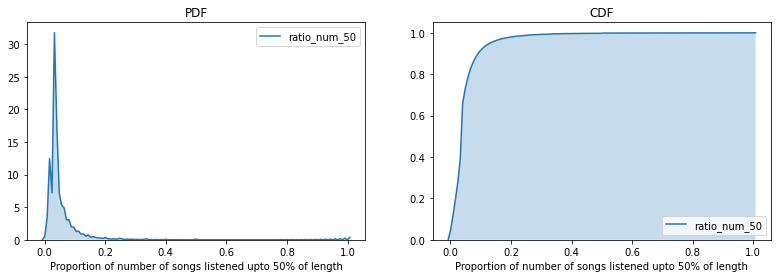

In [96]:
## kde plot of ratio_num_50 for users who churned
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['ratio_num_50'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 50% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['ratio_num_50'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 50% of length')
plt.title('CDF')

plt.show()


Text(0.5, 1.0, 'Users vs Proportion of number of songs listened upto 50% of length')

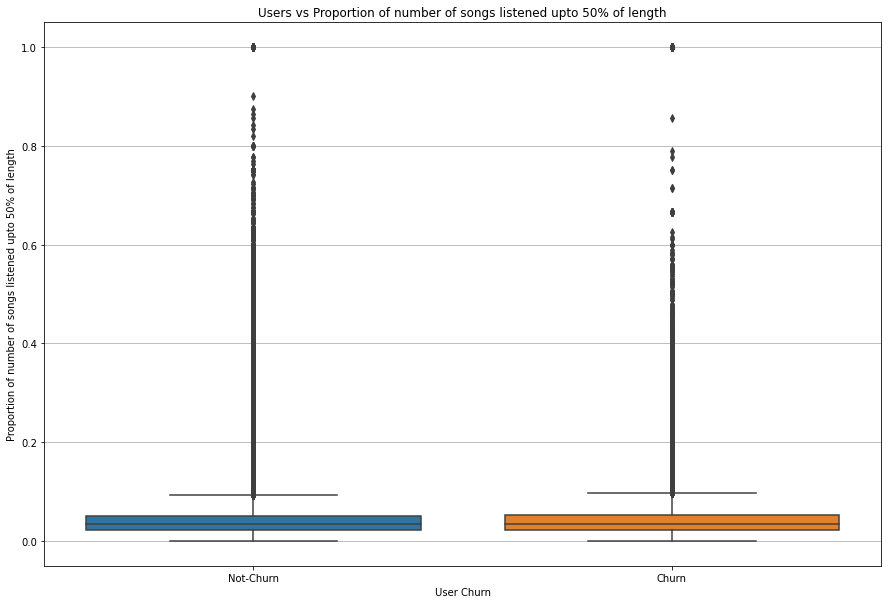

In [97]:
# BoxPlot of ratio_num_50 for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.ratio_num_50, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Proportion of number of songs listened upto 50% of length")
plt.title("Users vs Proportion of number of songs listened upto 50% of length")

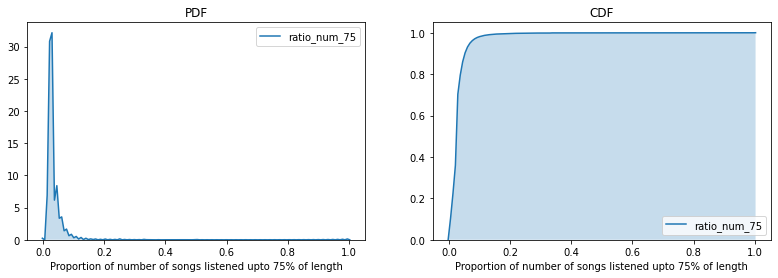

In [98]:
## kde plot of ratio_num_75 for users who did not churn
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['ratio_num_75'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 75% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['ratio_num_75'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 75% of length')
plt.title('CDF')

plt.show()

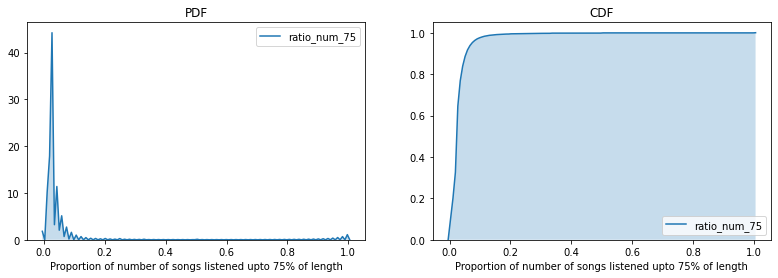

In [99]:
## kde plot of ratio_num_75 for users who churned
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['ratio_num_75'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 75% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['ratio_num_75'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 75% of length')
plt.title('CDF')

plt.show()


Text(0.5, 1.0, 'Users vs Proportion of number of songs listened upto 75% of length by users')

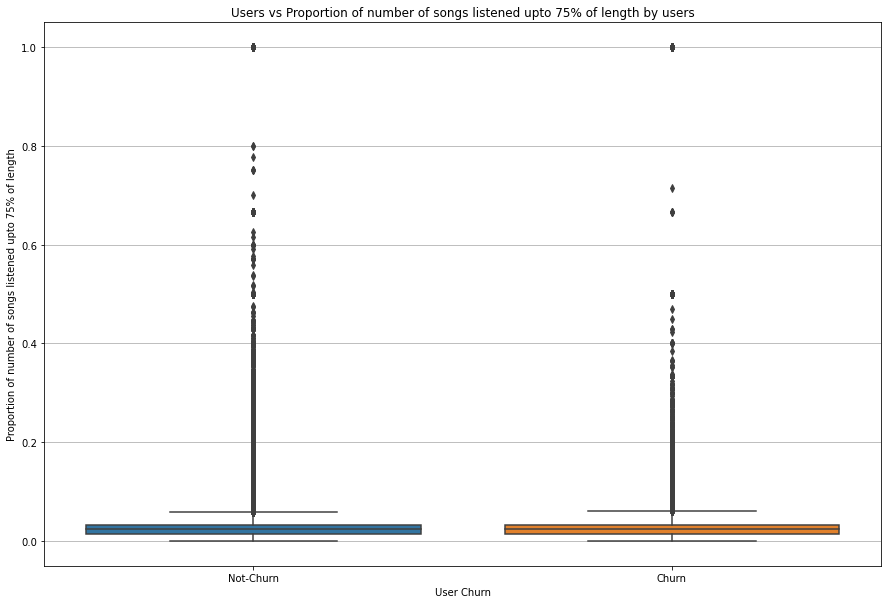

In [100]:
# BoxPlot of ratio_num_75 for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.ratio_num_75, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Proportion of number of songs listened upto 75% of length")
plt.title("Users vs Proportion of number of songs listened upto 75% of length by users")

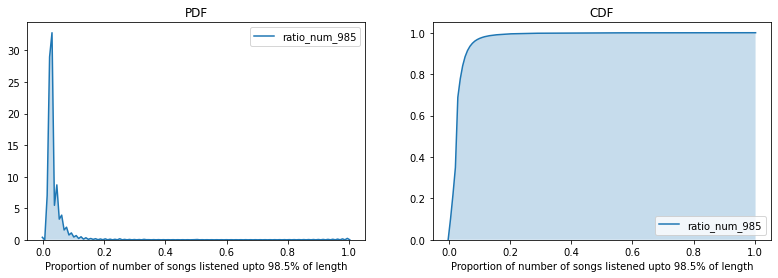

In [101]:
## kde plot of ratio_num_985 for users who did not churn
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['ratio_num_985'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 98.5% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['ratio_num_985'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 98.5% of length')
plt.title('CDF')

plt.show()

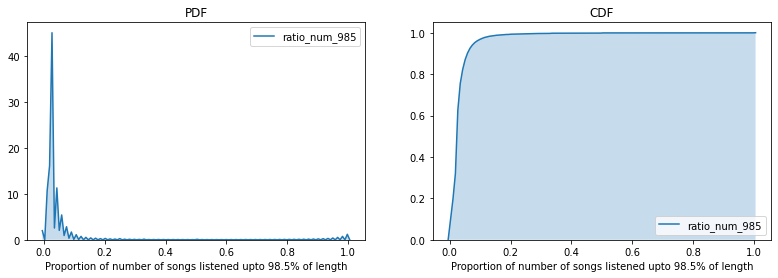

In [102]:
## kde plot of ratio_num_985 for users who churned
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['ratio_num_985'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 98.5% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['ratio_num_985'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 98.5% of length')
plt.title('CDF')

plt.show()


Text(0.5, 1.0, 'Users vs Proportion of number of songs listened upto 98.5% of length')

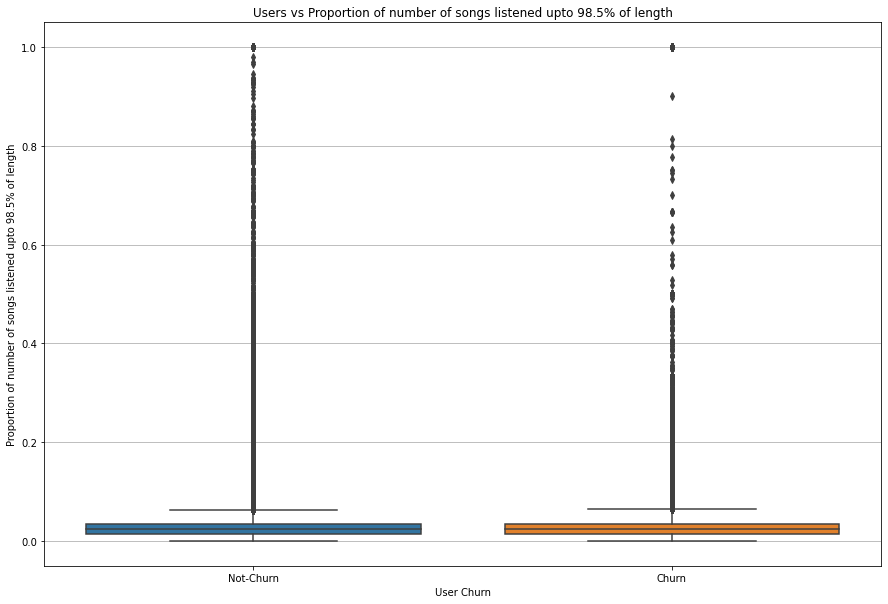

In [103]:
# BoxPlot of ratio_num_75 for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.ratio_num_985, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Proportion of number of songs listened upto 98.5% of length")
plt.title("Users vs Proportion of number of songs listened upto 98.5% of length")

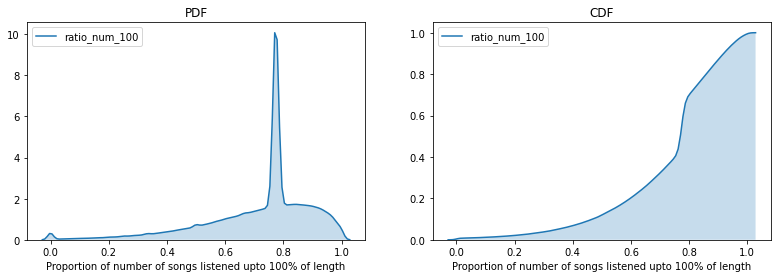

In [104]:
## kde plot of ratio_num_100 for users who did not churn
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['ratio_num_100'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 100% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['ratio_num_100'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 100% of length')
plt.title('CDF')

plt.show()

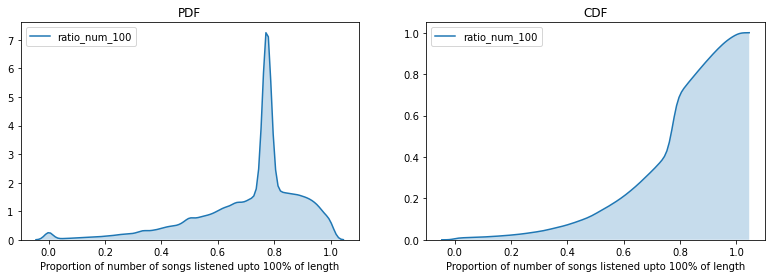

In [105]:
## kde plot of ratio_num_100 for users who churned
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==1]['ratio_num_100'], shade=True, ax=ax1)
plt.xlabel('Proportion of number of songs listened upto 100% of length')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==1]['ratio_num_100'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Proportion of number of songs listened upto 100% of length')
plt.title('CDF')

plt.show()


Text(0.5, 1.0, 'Users vs Proportion of number of songs listened upto 100% of length')

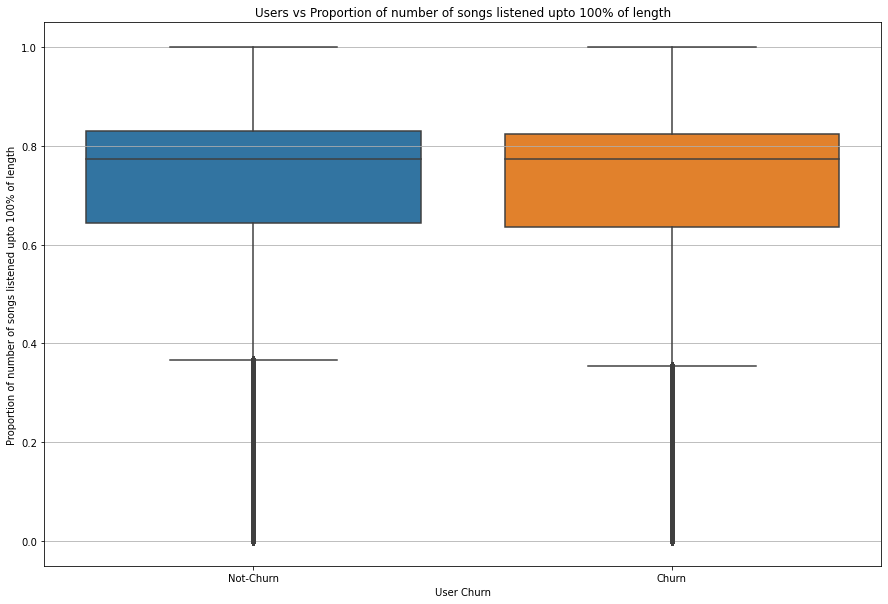

In [106]:
# BoxPlot of ratio_num_100 for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.ratio_num_100, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Proportion of number of songs listened upto 100% of length")
plt.title("Users vs Proportion of number of songs listened upto 100% of length")

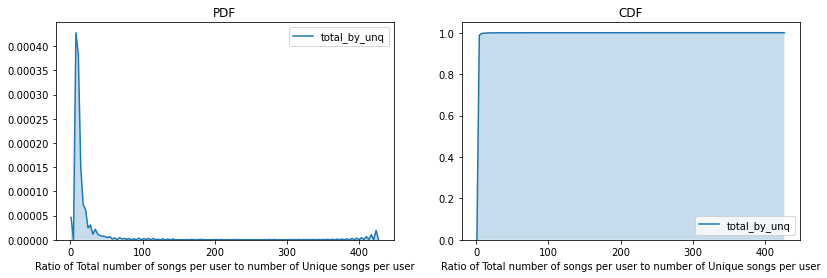

In [107]:
## kde plot of total_by_unq for users who did not churn
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['total_by_unq'], shade=True, ax=ax1)
plt.xlabel('Ratio of Total number of songs per user to number of Unique songs per user')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['total_by_unq'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Ratio of Total number of songs per user to number of Unique songs per user')
plt.title('CDF')

plt.show()

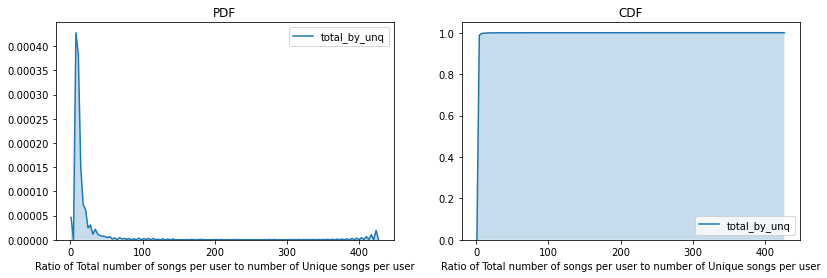

In [111]:
## kde plot of total_by_unq for users who did not churn
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sn.kdeplot(train[train.is_churn==0]['total_by_unq'], shade=True, ax=ax1)
plt.xlabel('Ratio of Total number of songs per user to number of Unique songs per user')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train[train.is_churn==0]['total_by_unq'], shade=True, cumulative=True, ax=ax2)
plt.xlabel('Ratio of Total number of songs per user to number of Unique songs per user')
plt.title('CDF')

plt.show()

Text(0.5, 1.0, 'Users vs Ratio of Total number of songs per user to number of Unique songs per user')

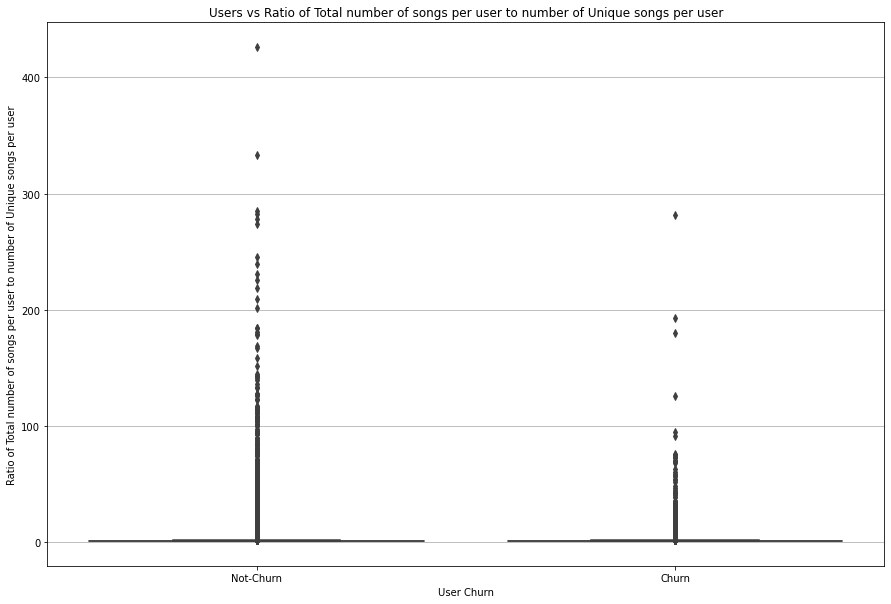

In [110]:
# BoxPlot of total_by_unq for churned and not-churned users
plt.figure(figsize=(15,10))
plt.grid()
sn.boxplot(y=train.total_by_unq, x=train.is_churn,orient='v')
plt.xticks([0, 1], ['Not-Churn', 'Churn'])
plt.xlabel("User Churn")
plt.ylabel("Ratio of Total number of songs per user to number of Unique songs per user")
plt.title("Users vs Ratio of Total number of songs per user to number of Unique songs per user")

In [161]:
# merging test labels with transactions dataframe
test = sample_submission_v2.merge(transactions_v2,how='left',on='msno')
#test.dropna(inplace=True)   # dropping datapoints that don't have any transactions

# merging members data for test dataset users
test = test.merge(members,how='left',on='msno')
#test.drop(columns=['bd'],axis=1,inplace=True)  # drop 'bd' (age) column

#filling categorical fetaures like city,registered_via etc, with mode values i.e. most occured value for that feature
#fill_with_mode(test,categorical_columns)

# merging test user's logs 
test = test.merge(user_logs, how='left',on='msno')
#test.dropna(inplace=True)   # dropping datapoints that dont have any logs

#filling categorical fetaures like city,registered_via etc, with mode values i.e. most occured value for that feature
fill_with_mode(test,categorical_columns)

#filling numerical fetaures with median values 
fill_with_median(test,numerical_columns)

test.drop(columns=['bd'],axis=1,inplace=True)  # drop 'bd' (age) column
#=====================================================================

# creating new features out of registration date 

# taking just day of month
test['day_of_month'] = test.transaction_date.apply(lambda x: np.int8(str(int(x))[6:]))

# taking removing year from the date and taking just month and day of month 
test['month_day'] = test.transaction_date.apply(lambda x: np.int16(str(int(x))[4:]))

# 'day_of_week' signifies which day of week it is. 
# e.g.  Monday is 1 and Sunday is 7
test['day_of_week'] = test.transaction_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").isoweekday())

# creating a feature 'is_weekend' which is '1' if the registration date is weekend i.e. Saturday or Sunday, else '0'
test['is_weekend'] = test.day_of_week.map(lambda x:1 if x in (6,7) else 0)

#=======================================================================================================

# creating a new feature - min_per_song i.e. average minutes listened per song

test['min_per_song'] = test['total_minutes']/(test['num_25']+test['num_50']+test['num_75']+test['num_985']+test['num_100'])

# creating a new feature - avg_min_per_unq i.e. average minutes listened per unique song

test['avg_min_per_unq'] = test['mean_total_min']/test['mean_num_unq']

#========================================================================================================

# creating a feature 'total_num' i.e. total number of songs listened by the user
test['total_num'] = test['num_25']+test['num_50']+test['num_75']+test['num_985']+test['num_100']

# creating a feature 'ratio_num_25' i.e. ratio of 'total_num'(total number of songs) and 'num_25'(number of songs listened upto 25% of their length)
# train['ratio_num_25'] = [train['total_num'][i]/train['num_25'][i] for i in range(train.shape[0])]
test['ratio_num_25'] = test['num_25']/test['total_num']

# creating a feature 'ratio_num_50' i.e. ratio of 'total_num'(total number of songs) and 'num_50'(number of songs listened upto 50% of their length)
test['ratio_num_50'] = test['num_50']/test['total_num']

# creating a feature 'ratio_num_75' i.e. ratio of 'total_num'(total number of songs) and 'num_75'(number of songs listened upto 75% of their length)
test['ratio_num_75'] = test['num_75']/test['total_num']

# creating a feature 'ratio_num_985' i.e. ratio of 'total_num'(total number of songs) and 'num_985'(number of songs listened upto 98.5% of their length)
test['ratio_num_985'] = test['num_985']/test['total_num']

# creating a feature 'ratio_num_100' i.e. ratio of 'total_num'(total number of songs) and 'num_100'(number of songs listened upto 100% of their length)
test['ratio_num_100'] = test['num_100']/test['total_num']

# creating a feature 'total_by_unq' i.e. total_num divided by num_unq
test['total_by_unq'] = test['total_num']/test['num_unq']

print(test.shape)
test.head()

(907471, 44)


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,transaction_date,trans_count,city,registered_via,...,is_weekend,min_per_song,avg_min_per_unq,total_num,ratio_num_25,ratio_num_50,ratio_num_75,ratio_num_985,ratio_num_100,total_by_unq
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,41.0,30.0,99.0,1.0,20170318.0,1.0,1.0,7.0,...,1,3.495780,4.080616,394.0,0.139594,0.035533,0.025381,0.025381,0.774112,1.193939
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,34.0,30.0,149.0,1.0,20170331.0,1.0,4.0,9.0,...,0,3.110962,3.672112,2683.0,0.204994,0.065598,0.046590,0.048826,0.633992,1.180378
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,41.0,30.0,99.0,1.0,20170315.0,1.0,4.0,7.0,...,0,2.145430,2.663789,185.0,0.427027,0.102703,0.005405,0.010811,0.454054,1.241611
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,41.0,30.0,99.0,1.0,20170327.0,1.0,1.0,7.0,...,0,3.495780,4.080616,394.0,0.139594,0.035533,0.025381,0.025381,0.774112,1.193939
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,30.0,30.0,129.0,1.0,20170322.0,1.0,1.0,13.0,...,0,3.495780,4.080616,394.0,0.139594,0.035533,0.025381,0.025381,0.774112,1.193939


In [162]:
# dropping std dev features

test.drop(columns=['std_num_25', 'std_num_50', 'std_num_75',
       'std_num_985', 'std_num_100', 'std_num_unq', 'std_total_min'], axis=1, inplace=True)

In [163]:
test.shape

(907471, 37)

Total 20 new features are created - `'mean_num_25', 'mean_num_50','mean_num_75', 'mean_num_985', 'mean_num_100', 'mean_num_unq',
'mean_total_min', 'day_of_month', 'month_day', 'day_of_week','is_weekend', 'min_per_song', 'avg_min_per_unq', 'total_num',
 'ratio_num_25', 'ratio_num_50', 'ratio_num_75', 'ratio_num_985','ratio_num_100', 'total_by_unq' `

### MODEL - LightGBM Classifier

In [3]:
# getting rows where is_churn =1 i.e. churned users
train1 = train[train.is_churn==1]
train1.shape

(87330, 37)

In [4]:
# getting rows where is_churn = 0 i.e. not-churned users
train0 = train[train.is_churn==0]
train0.shape

(883630, 37)

In [5]:
# taking random samples from not-churned users data
# size of sample is thrice the size of dataset of churned users

train0_sample = train0.sample(n=3*train1.shape[0],random_state=10)
train0_sample.reset_index(drop=True,inplace=True)
train
print(train0_sample.shape)
train0_sample.head()

(261990, 37)


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,transaction_date,trans_count,city,registered_via,...,is_weekend,min_per_song,avg_min_per_unq,total_num,ratio_num_25,ratio_num_50,ratio_num_75,ratio_num_985,ratio_num_100,total_by_unq
0,SF8v8hrQ+3VS0UyLyLMxYaip7y3FzMO53qF3j7bgNpo=,0,41.0,30.0,149.0,1.0,20170318.0,1.0,1.0,7.0,...,1,3.454088,6.280161,20.0,0.050000,0.050000,0.100000,0.250000,0.550000,1.818182
1,k5kG78Cgm3TnYO3VDeDoNjNrLD1c1D65ya0J4zqtNFE=,0,41.0,30.0,99.0,1.0,20170319.0,1.0,1.0,7.0,...,1,2.284520,2.944221,241.0,0.385892,0.053942,0.037344,0.024896,0.497925,1.288770
2,+9AIxUPMeiKx5sJVpw2Wig+Uby7ghyjTemXFUDYQIZ4=,0,41.0,30.0,149.0,1.0,20170331.0,1.0,1.0,9.0,...,0,3.095796,3.213957,136.0,0.250000,0.058824,0.029412,0.007353,0.654412,1.038168
3,sJMN0LkXb+ehWvg4FO5RNrcPQ5fPqJUeF7l8M2IbUeg=,0,41.0,30.0,99.0,1.0,20170331.0,1.0,1.0,7.0,...,0,3.396634,9.487151,162.0,0.111111,0.024691,0.024691,0.037037,0.802469,2.793103
4,zDymX7543CnaqDN4VgNejLXnkEpLQR/HZYxp5pj6oTc=,0,41.0,30.0,99.0,1.0,20170302.0,1.0,1.0,7.0,...,0,3.495780,4.080616,394.0,0.139594,0.035533,0.025381,0.025381,0.774112,1.193939


In [6]:
# appending churned and not-churned users datasets
# proportion of chunred users is 25% of the total sampled data

train_df = train0_sample.append(train1)
print(train_df.shape)
train_df.head()

(349320, 37)


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,transaction_date,trans_count,city,registered_via,...,is_weekend,min_per_song,avg_min_per_unq,total_num,ratio_num_25,ratio_num_50,ratio_num_75,ratio_num_985,ratio_num_100,total_by_unq
0,SF8v8hrQ+3VS0UyLyLMxYaip7y3FzMO53qF3j7bgNpo=,0,41.0,30.0,149.0,1.0,20170318.0,1.0,1.0,7.0,...,1,3.454088,6.280161,20.0,0.050000,0.050000,0.100000,0.250000,0.550000,1.818182
1,k5kG78Cgm3TnYO3VDeDoNjNrLD1c1D65ya0J4zqtNFE=,0,41.0,30.0,99.0,1.0,20170319.0,1.0,1.0,7.0,...,1,2.284520,2.944221,241.0,0.385892,0.053942,0.037344,0.024896,0.497925,1.288770
2,+9AIxUPMeiKx5sJVpw2Wig+Uby7ghyjTemXFUDYQIZ4=,0,41.0,30.0,149.0,1.0,20170331.0,1.0,1.0,9.0,...,0,3.095796,3.213957,136.0,0.250000,0.058824,0.029412,0.007353,0.654412,1.038168
3,sJMN0LkXb+ehWvg4FO5RNrcPQ5fPqJUeF7l8M2IbUeg=,0,41.0,30.0,99.0,1.0,20170331.0,1.0,1.0,7.0,...,0,3.396634,9.487151,162.0,0.111111,0.024691,0.024691,0.037037,0.802469,2.793103
4,zDymX7543CnaqDN4VgNejLXnkEpLQR/HZYxp5pj6oTc=,0,41.0,30.0,99.0,1.0,20170302.0,1.0,1.0,7.0,...,0,3.495780,4.080616,394.0,0.139594,0.035533,0.025381,0.025381,0.774112,1.193939


In [7]:
X = train_df.drop(columns=['msno','is_churn','transaction_date','is_weekend'],axis=1)
print(X.shape)

y = train_df['is_churn']
print(y.shape)


(349320, 33)
(349320,)


In [8]:
# splitting data into train and test sets 
from sklearn.model_selection import train_test_split
xtr,xte,ytr,yte = train_test_split(X,y,test_size=0.2,stratify=y)

In [11]:
# performing cross-validation using RandomizedSearchCV to identify best parameters
lgb = LGBMClassifier(n_jobs=-1)

param = {
    'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14],
    'learning_rate':[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.7,0.8,1],
    'subsample':[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1],
    'n_estimators':[50,75,100,150,200,250,300,400,500,600,700,800],
    'num_leaves':[31,35,40,45,50,55,60,65,70,75,80,90,100]
}

random_clf = RandomizedSearchCV(lgb,param_distributions=param,cv=8,verbose=1,n_jobs=-1)
random_clf.fit(xtr,ytr)

print("Best Parameters = ", random_clf.best_params_)

best_param = random_clf.best_params_

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.9min finished


Best Parameters =  {'subsample': 0.5, 'num_leaves': 90, 'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.15, 'colsample_bytree': 1}


In [12]:
# training LGBMClassifier with best identified parameters
lgb = LGBMClassifier(max_depth=best_param['max_depth'],subsample=best_param['subsample'],
                     learning_rate=best_param['learning_rate'],n_estimators=best_param['n_estimators'],
                     num_leaves=best_param['num_leaves'],colsample_bytree=best_param['colsample_bytree'],n_jobs=-1)

lgb.fit(xtr,ytr)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
               importance_type='split', learning_rate=0.15, max_depth=14,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=90, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

In [13]:
# checking accuracy on train and test dataset
ytr_pred = lgb.predict(xtr)
print("Train Accuracy = ",accuracy_score(ytr,ytr_pred))

yte_pred = lgb.predict(xte)
print("Test Accuracy = ",accuracy_score(yte,yte_pred))

Train Accuracy =  0.9266968682010763
Test Accuracy =  0.9230791251574487


In [14]:
# checking log-loss on train and test dataset
ytr_pred_prob = lgb.predict_proba(xtr)
print("Train Loss = ",log_loss(ytr,ytr_pred_prob))

yte_pred_prob = lgb.predict_proba(xte)
print("Test Loss = ",log_loss(yte,yte_pred_prob))

Train Loss =  0.19647702662024685
Test Loss =  0.2063102720037139


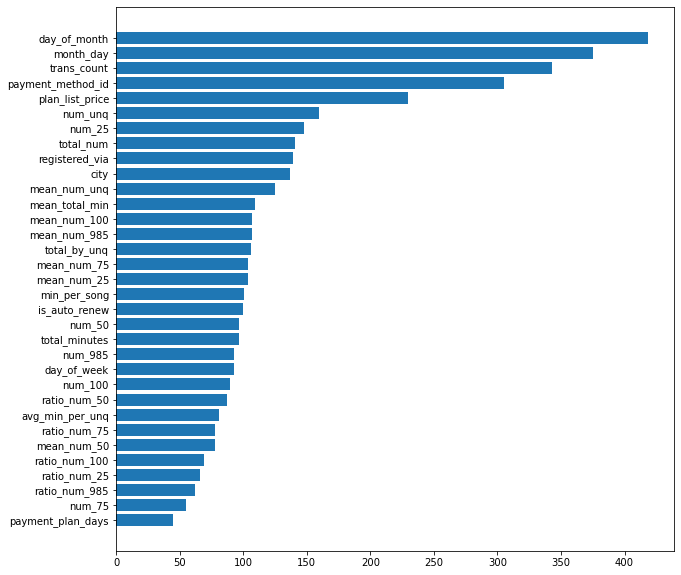

In [15]:
# plotting feature importance scores
plt.figure(figsize=(10,10))

feature_index = np.argsort(lgb.feature_importances_)

feature_imp = lgb.feature_importances_

feature_names = np.array(X.columns)

plt.barh(range(len(feature_imp)), feature_imp[feature_index])
plt.yticks(range(len(feature_imp)),feature_names[feature_index])
plt.show()

In [16]:
# test data provided by kaggle
test_x = test.drop(columns=['msno','is_churn','transaction_date','is_weekend'],axis=1)
print(test_x.shape)

test_y = test['is_churn'].copy()
print(test_y.shape)

(907471, 33)
(907471,)


In [17]:
# checking accuracy and loss on test data provided by kaggle
test_pred1 = lgb.predict(test_x)
print("Accuracy = ", accuracy_score(test_y,test_pred1))

#test_pred_prob = (lgb.predict_proba(test_x)).clip(0.+1e-15, 1-1e-15)
test_pred_prob1 = lgb.predict_proba(test_x)
print("Loss = ", log_loss(test_y,test_pred_prob1, labels=[0,1]))

Accuracy =  0.9375539273431327
Loss =  0.30691373765901786


In [18]:
# taking probalities of is_churn = 1 i.e. churned users
test_pred_prob1 = [p[1] for p in test_pred_prob1]

In [19]:
# creating dataframe with msno and probabilities of is_churn = 1, to submit on kaggle
submission_lgb = pd.DataFrame()
submission_lgb['msno'] = test['msno']
submission_lgb['is_churn'] = test_pred_prob1
print(submission_lgb.shape)
submission_lgb.to_csv("submission_lgb.csv",index=False)

(907471, 2)


##### LGBMClassifier performs well with Train accuracy = 92.6% and Test accuracy = 92.3%. 
##### Train loss = 0.196 and Test loss = 0.206.
##### Loss on kaggle test data is 0.306.
#####  Kaggle score is 0.29775

### Feed Forward Neural Network

In [25]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

tensorflow.config.set_soft_device_placement(True)
tensorflow.debugging.set_log_device_placement(True)

In [21]:
# function to convert class_label to one-hot encoded
def onehot(col):
    col = list(col)
    arr = np.zeros((len(col),2))
    for i,val in enumerate(col):
        arr[i,val] = 1
    return arr


In [22]:
# one-hot encoding class label y
ytr_oh = onehot(ytr)
yte_oh = onehot(yte)
ytr_oh.shape

(279456, 2)

In [32]:
# defining model architecture

model = Sequential()

model.add(Dense(512,activation='relu',input_shape=(33,)))

model.add(Dropout(0.3))

model.add(Dense(256,activation='relu'))

model.add(Dropout(0.3))

model.add(BatchNormalization())

model.add(Dense(128,activation='relu'))

model.add(Dropout(0.1))

model.add(Dense(2,activation='softmax'))

opt = tensorflow.keras.optimizers.Adam(0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
# checkpoint model to save best weights
checkpt = ModelCheckpoint("best_weights2.h5",monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch')

# training model 
model.fit(xtr,ytr_oh,batch_size=512, epochs=25,validation_data=(xte,yte_oh),callbacks=[checkpt])

Train on 279456 samples, validate on 69864 samples
Epoch 1/25
279040/279456 [============================>.] - ETA: 0s - loss: 0.4768 - acc: 0.7933
Epoch 00001: val_loss improved from inf to 0.45459, saving model to best_weights2.h5
279456/279456 [==============================] - 15s 55us/sample - loss: 0.4768 - acc: 0.7933 - val_loss: 0.4546 - val_acc: 0.8018
Epoch 2/25
278016/279456 [============================>.] - ETA: 0s - loss: 0.4293 - acc: 0.8172
Epoch 00002: val_loss improved from 0.45459 to 0.41100, saving model to best_weights2.h5
279456/279456 [==============================] - 15s 52us/sample - loss: 0.4292 - acc: 0.8173 - val_loss: 0.4110 - val_acc: 0.8223
Epoch 3/25
278528/279456 [============================>.] - ETA: 0s - loss: 0.4070 - acc: 0.8354
Epoch 00003: val_loss did not improve from 0.41100
279456/279456 [==============================] - 14s 52us/sample - loss: 0.4070 - acc: 0.8354 - val_loss: 0.4110 - val_acc: 0.8273
Epoch 4/25
279040/279456 [==============

In [34]:
# prediction on test data
test_pred_prob2 = (model.predict(test_x))
testpred = [np.argmax(test_pred_prob2[i]) for i in range(test_x.shape[0])]

In [35]:
# taking probalities of class 1 i.e. churned users
test_pred_prob_ = [p[1] for p in test_pred_prob2]

In [36]:
print("Accuracy = ", accuracy_score(test_y,testpred))

print("Loss = ", log_loss(test_y,test_pred_prob2,labels=[0,1]))

Accuracy =  0.9593066885883956
Loss =  0.22286326321712713


In [37]:
# creating dataframe with msno and probabilities of is_churn = 1, to submit on kaggle
submission_nn = pd.DataFrame()
submission_nn['msno'] = test['msno']
submission_nn['is_churn'] = test_pred_prob_
print(submission_nn.shape)
submission_nn.to_csv("submission_nn.csv",index=False)

(907471, 2)


##### The above Neural network performs well. Test Loss of the model is 0.222 and Test Accuracy is 95.93%.
##### Kaggle score is 0.25171

`NOTE: For LightGBM Kaggle score, refer to attached screenshot - kaggle_score_lgb.jpg`

`For Neural Network Kaggle score, refer to attached screenshot - kaggle_score_nn.jpg`